In [1]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools

directory = "/Users/archiebrooks/Documents/Uni/mphys_project/all_matched_data_0312/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/all_matched_data_0312/"

hep.style.use('ATLAS')

## Function Definitions

In [2]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        colours = ['#235789','#c1292e','#F26419']
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step', color = colours[i])
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    if density: axes.set_ylabel(f'Normalised Events /{bin_width:.2g} {x_units}')
    else: axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}', color = colours[-i])
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

In [35]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV', print_peak=False):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        colours = ['#235789','#c1292e','#20BF55', '#33658A']
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))

            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
        
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step', color = colours[i])
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step', color = colours[i])
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
            if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label[i]}: {peak_bin_center:.2f} {x_units}")
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data)
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step', color = colours[i])
        if print_peak:
                peak_bin_index = np.argmax(hist.counts())
                peak_bin_center = (hist.axes[0].edges[peak_bin_index] + hist.axes[0].edges[peak_bin_index + 1]) / 2
                print(f"Peak bin center for {data_label}: {peak_bin_center:.2f} {x_units}")

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    if density: axes.set_ylabel(f'Normalised Events /{bin_width:.2g} {x_units}')
    else: axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

def duplicate_cleaner(matched_pairs, truth=None):
    truth_ids = matched_pairs['truth']['id']
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(truth_ids)])
    no_repeats = ak.num(deduped_id_pairs) == ak.num(truth_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(truth_ids) - 1

    duplicate_pairs = matched_pairs[one_repeat]
    clean_pairs = matched_pairs[no_repeats]
    if truth is not None:
        duplicate_truth = truth[one_repeat]
        return clean_pairs, duplicate_pairs, duplicate_truth
    
    return clean_pairs, duplicate_pairs, no_repeats

def duplicate_matcher(repeat, dupe_truth):
    fixable_repeats = repeat[ak.num(repeat)>2]

    repeat_truth, valid_particles, duplicate_particles = [], [], []

    print('going into for loop')

    for i in range(1,len(dupe_truth[0])+1):

        repeat_ids = fixable_repeats['truth']['id']
        repeat_i = fixable_repeats[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_ids_i = repeat_ids[ak.num(repeat_ids[repeat_ids==i], axis=1)==2]
        repeat_truth.append(dupe_truth[ak.num(repeat_ids[repeat_ids==i], axis=1)==2])

        valid_particles.append(repeat_i[repeat_ids_i!=i])
        duplicate_particles.append(repeat_i[repeat_ids_i==i])

    print('out of for loop')

    repeat_truth = ak.concatenate(repeat_truth)
    valid_particles = [ak.concatenate(valid_particles)]
    duplicate_particles = ak.concatenate(duplicate_particles)
    id = np.tile(np.arange(1,len(repeat_truth[0])+1), (len(repeat_truth),1))
    repeat_truth_zip = ak.zip({'truth': repeat_truth, 'id': id})

    duplicate_deltars = duplicate_particles['reco'].deltaR(duplicate_particles['truth']['truth'])
    min_dupdeltars = ak.min(duplicate_deltars, axis=1)

    valid_particles.append(duplicate_particles[duplicate_deltars==min_dupdeltars])
    invalid_particles = duplicate_particles['reco'][duplicate_deltars!=min_dupdeltars]

    second_pass = ak.cartesian({'reco': invalid_particles, 'truth': repeat_truth_zip})
    second_deltars = second_pass['reco'].deltaR(second_pass['truth']['truth'])

    second_smallest_dr = ak.sort(second_deltars)[:,1]
    valid_particles.append(second_pass[(second_deltars==second_smallest_dr)&(second_smallest_dr<0.4)])
    print("pre concat")
    valid_particles = ak.concatenate(valid_particles, axis=1)
    print("post concat")
    return valid_particles

def truth_matching(truth, truth_id, reco_jets, reco_leptons):
    print(len(truth[0]))

    indexed_truth = ak.zip({'truth': truth, 'id': ak.local_index(truth)+1})
    
    truth_jets = indexed_truth[np.abs(truth_id) < 10]
    truth_leptons = indexed_truth[(np.abs(truth_id) > 10)&(np.abs(truth_id)<20)]

    jets_3d = ak.cartesian({'reco':reco_jets, 'truth': truth_jets}, axis=1, nested=True)

    deltars = jets_3d['reco'].deltaR(jets_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_jets = ak.flatten(jets_3d[(deltars==min_deltars)&(min_deltars<0.4)], axis=2)


    leptons_3d = ak.cartesian({'truth': truth_leptons, 'reco':reco_leptons}, axis=1, nested=True)

    deltars = leptons_3d['reco'].deltaR(leptons_3d['truth']['truth'])
    min_deltars = ak.min(deltars,axis=2)

    matched_leptons = ak.flatten(leptons_3d[(deltars==min_deltars)&(min_deltars<0.1)], axis=2)

    matched = ak.concatenate((matched_jets, matched_leptons), axis=1)

    matched_pairs, repeat_pairs, matched_bools = duplicate_cleaner(matched)
    print(len(repeat_pairs))

    print("starting dm")

    #valid_particles = duplicate_matcher(repeat_pairs, repeat_truth)

    print("starting axis=0 concat")

    #matched_events = ak.concatenate((matched_pairs, valid_particles), axis=0)
    matched_events = matched_pairs
    
    return matched_events, matched_bools

def top_identifier(matched_data, process, lepton_channel, lepton_indices=None):
    """
    Takes the matched, duplicate free data and trys to reconstruct any tops it can
    """

    if process=="4t":
        if lepton_channel == "0L":
            truth_tops_1 = matched_data['truth']['truth'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==5)|(matched_data['truth']['id']==6)]
            truth_tops_2 = matched_data['truth']['truth'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==7)|(matched_data['truth']['id']==8)]
            truth_tops_3 = matched_data['truth']['truth'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==9)|(matched_data['truth']['id']==10)]
            truth_tops_4 = matched_data['truth']['truth'][(matched_data['truth']['id']==4)|(matched_data['truth']['id']==11)|(matched_data['truth']['id']==12)]

            reco_tops_1 = matched_data['reco'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==5)|(matched_data['truth']['id']==6)]
            reco_tops_2 = matched_data['reco'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==7)|(matched_data['truth']['id']==8)]
            reco_tops_3 = matched_data['reco'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==9)|(matched_data['truth']['id']==10)]
            reco_tops_4 = matched_data['reco'][(matched_data['truth']['id']==4)|(matched_data['truth']['id']==11)|(matched_data['truth']['id']==12)]

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==3)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)
            truth_tops_4 = ak.mask(truth_tops_4, ak.num(truth_tops_4)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==3)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)
            reco_tops_4 = ak.mask(reco_tops_4, ak.num(reco_tops_4)==3)

        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            truth_tops_1_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            truth_tops_2_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            truth_tops_3_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            truth_tops_4_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            reco_tops_1_01 = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==5)]
            reco_tops_2_01 = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==6)]
            reco_tops_3_01 = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==7)|(matched_01['truth']['id']==8)]
            reco_tops_4_01 = matched_01['reco'][(matched_01['truth']['id']==4)|(matched_01['truth']['id']==9)|(matched_01['truth']['id']==10)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            truth_tops_1_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            truth_tops_3_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            truth_tops_2_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            truth_tops_4_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            reco_tops_1_03 = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==5)]
            reco_tops_3_03 = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==6)|(matched_03['truth']['id']==7)]
            reco_tops_2_03 = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==8)]
            reco_tops_4_03 = matched_03['reco'][(matched_03['truth']['id']==4)|(matched_03['truth']['id']==9)|(matched_03['truth']['id']==10)]

            matched_05 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==5)]
            truth_tops_1_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            truth_tops_3_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            truth_tops_4_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            truth_tops_2_05 = matched_05['truth']['truth'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            reco_tops_1_05 = matched_05['reco'][(matched_05['truth']['id']==1)|(matched_05['truth']['id']==5)]
            reco_tops_3_05 = matched_05['reco'][(matched_05['truth']['id']==2)|(matched_05['truth']['id']==6)|(matched_05['truth']['id']==7)]
            reco_tops_4_05 = matched_05['reco'][(matched_05['truth']['id']==3)|(matched_05['truth']['id']==8)|(matched_05['truth']['id']==9)]
            reco_tops_2_05 = matched_05['reco'][(matched_05['truth']['id']==4)|(matched_05['truth']['id']==10)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            truth_tops_3_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            truth_tops_1_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            truth_tops_2_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            truth_tops_4_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            reco_tops_3_23 = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==5)|(matched_23['truth']['id']==6)]
            reco_tops_1_23 = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==7)]
            reco_tops_2_23 = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==8)]
            reco_tops_4_23 = matched_23['reco'][(matched_23['truth']['id']==4)|(matched_23['truth']['id']==9)|(matched_23['truth']['id']==10)]

            matched_25 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==5)]
            truth_tops_3_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            truth_tops_1_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            truth_tops_4_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            truth_tops_2_25 = matched_25['truth']['truth'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            reco_tops_3_25 = matched_25['reco'][(matched_25['truth']['id']==1)|(matched_25['truth']['id']==5)|(matched_25['truth']['id']==6)]
            reco_tops_1_25 = matched_25['reco'][(matched_25['truth']['id']==2)|(matched_25['truth']['id']==7)]
            reco_tops_4_25 = matched_25['reco'][(matched_25['truth']['id']==3)|(matched_25['truth']['id']==8)|(matched_25['truth']['id']==9)]
            reco_tops_2_25 = matched_25['reco'][(matched_25['truth']['id']==4)|(matched_25['truth']['id']==10)]

            matched_45 = matched_data[lepton_indices[:,0]==4]
            truth_tops_3_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            truth_tops_4_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            truth_tops_1_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            truth_tops_2_45 = matched_45['truth']['truth'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            reco_tops_3_45 = matched_45['reco'][(matched_45['truth']['id']==1)|(matched_45['truth']['id']==5)|(matched_45['truth']['id']==6)]
            reco_tops_4_45 = matched_45['reco'][(matched_45['truth']['id']==2)|(matched_45['truth']['id']==7)|(matched_45['truth']['id']==8)]
            reco_tops_1_45 = matched_45['reco'][(matched_45['truth']['id']==3)|(matched_45['truth']['id']==9)]
            reco_tops_2_45 = matched_45['reco'][(matched_45['truth']['id']==4)|(matched_45['truth']['id']==10)]

            truth_tops_1 = ak.concatenate((truth_tops_1_01, truth_tops_1_03, truth_tops_1_05, truth_tops_1_23, truth_tops_1_25, truth_tops_1_45))
            truth_tops_2 = ak.concatenate((truth_tops_2_01, truth_tops_2_03, truth_tops_2_05, truth_tops_2_23, truth_tops_2_25, truth_tops_2_45))
            truth_tops_3 = ak.concatenate((truth_tops_3_01, truth_tops_3_03, truth_tops_3_05, truth_tops_3_23, truth_tops_3_25, truth_tops_3_45))
            truth_tops_4 = ak.concatenate((truth_tops_4_01, truth_tops_4_03, truth_tops_4_05, truth_tops_4_23, truth_tops_4_25, truth_tops_4_45))

            reco_tops_1 = ak.concatenate((reco_tops_1_01, reco_tops_1_03, reco_tops_1_05, reco_tops_1_23, reco_tops_1_25, reco_tops_1_45))
            reco_tops_2 = ak.concatenate((reco_tops_2_01, reco_tops_2_03, reco_tops_2_05, reco_tops_2_23, reco_tops_2_25, reco_tops_2_45))
            reco_tops_3 = ak.concatenate((reco_tops_3_01, reco_tops_3_03, reco_tops_3_05, reco_tops_3_23, reco_tops_3_25, reco_tops_3_45))
            reco_tops_4 = ak.concatenate((reco_tops_4_01, reco_tops_4_03, reco_tops_4_05, reco_tops_4_23, reco_tops_4_25, reco_tops_4_45))

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==2)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==2)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)
            truth_tops_4 = ak.mask(truth_tops_4, ak.num(truth_tops_4)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==2)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==2)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)
            reco_tops_4 = ak.mask(reco_tops_4, ak.num(reco_tops_4)==3)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)
        truth_top_4 = ak.unflatten(ak.sum(truth_tops_4, axis=1), 1)

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)
        reco_top_4 = ak.unflatten(ak.sum(reco_tops_4, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1))

        sm_mask, dm_mask, tm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3), (ak.num(all_truth_tops)==4)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        tm_truth_tops, tm_reco_tops = all_truth_tops[tm_mask], all_reco_tops[tm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [tm_truth_tops, tm_reco_tops], [fm_truth_tops, fm_reco_tops]
    elif (process=="3tj")|(process=="3tW"):
        if lepton_channel == "0L":
            truth_tops_1 = matched_data['truth']['truth'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==4)|(matched_data['truth']['id']==5)]
            truth_tops_2 = matched_data['truth']['truth'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==6)|(matched_data['truth']['id']==7)]
            truth_tops_3 = matched_data['truth']['truth'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==8)|(matched_data['truth']['id']==9)]

            reco_tops_1 = matched_data['reco'][(matched_data['truth']['id']==1)|(matched_data['truth']['id']==4)|(matched_data['truth']['id']==5)]
            reco_tops_2 = matched_data['reco'][(matched_data['truth']['id']==2)|(matched_data['truth']['id']==6)|(matched_data['truth']['id']==7)]
            reco_tops_3 = matched_data['reco'][(matched_data['truth']['id']==3)|(matched_data['truth']['id']==8)|(matched_data['truth']['id']==9)]

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==3)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==3)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)

        elif lepton_channel == "2L":

            matched_01 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==1)]
            truth_tops_1_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            truth_tops_2_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            truth_tops_3_01 = matched_01['truth']['truth'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            reco_tops_1_01 = matched_01['reco'][(matched_01['truth']['id']==1)|(matched_01['truth']['id']==4)]
            reco_tops_2_01 = matched_01['reco'][(matched_01['truth']['id']==2)|(matched_01['truth']['id']==5)]
            reco_tops_3_01 = matched_01['reco'][(matched_01['truth']['id']==3)|(matched_01['truth']['id']==6)|(matched_01['truth']['id']==7)]

            matched_03 = matched_data[(lepton_indices[:,0]==0)&(lepton_indices[:,1]==3)]
            truth_tops_1_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            truth_tops_3_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            truth_tops_2_03 = matched_03['truth']['truth'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            reco_tops_1_03 = matched_03['reco'][(matched_03['truth']['id']==1)|(matched_03['truth']['id']==4)]
            reco_tops_3_03 = matched_03['reco'][(matched_03['truth']['id']==2)|(matched_03['truth']['id']==5)|(matched_03['truth']['id']==6)]
            reco_tops_2_03 = matched_03['reco'][(matched_03['truth']['id']==3)|(matched_03['truth']['id']==7)]

            matched_23 = matched_data[(lepton_indices[:,0]==2)&(lepton_indices[:,1]==3)]
            truth_tops_3_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            truth_tops_1_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            truth_tops_2_23 = matched_23['truth']['truth'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            reco_tops_3_23 = matched_23['reco'][(matched_23['truth']['id']==1)|(matched_23['truth']['id']==4)|(matched_23['truth']['id']==5)]
            reco_tops_1_23 = matched_23['reco'][(matched_23['truth']['id']==2)|(matched_23['truth']['id']==6)]
            reco_tops_2_23 = matched_23['reco'][(matched_23['truth']['id']==3)|(matched_23['truth']['id']==7)]

            truth_tops_1 = ak.concatenate((truth_tops_1_01, truth_tops_1_03, truth_tops_1_23))
            truth_tops_2 = ak.concatenate((truth_tops_2_01, truth_tops_2_03, truth_tops_2_23))
            truth_tops_3 = ak.concatenate((truth_tops_3_01, truth_tops_3_03, truth_tops_3_23))

            reco_tops_1 = ak.concatenate((reco_tops_1_01, reco_tops_1_03, reco_tops_1_23))
            reco_tops_2 = ak.concatenate((reco_tops_2_01, reco_tops_2_03, reco_tops_2_23))
            reco_tops_3 = ak.concatenate((reco_tops_3_01, reco_tops_3_03, reco_tops_3_23))

            truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==2)
            truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==2)
            truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)

            reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==2)
            reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==2)
            reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1))

        sm_mask, dm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [fm_truth_tops, fm_reco_tops]
    
def top_identifier_neutrino(matched_data, neutrinos, process, lepton_channel, lepton_indices=None):
    """
    Takes the matched, duplicate free data and trys to reconstruct any tops it can
    """

    if process=="4t":
        print('In top identifier')
        matched_0 = matched_data[(lepton_indices[:,0]==0)]
        neutrinos_0 = neutrinos[(lepton_indices[:,0]==0)]
        truth_tops_1_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
        truth_tops_2_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
        truth_tops_3_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
        truth_tops_4_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

        reco_tops_1_0 = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==5)]
        reco_tops_2_0 = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==6)|(matched_0['truth']['id']==7)]
        reco_tops_3_0 = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==8)|(matched_0['truth']['id']==9)]
        reco_tops_4_0 = matched_0['reco'][(matched_0['truth']['id']==4)|(matched_0['truth']['id']==10)|(matched_0['truth']['id']==11)]

        matched_2 = matched_data[(lepton_indices[:,0]==2)]
        neutrinos_2 = neutrinos[(lepton_indices[:,0]==2)]
        truth_tops_2_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
        truth_tops_1_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
        truth_tops_3_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
        truth_tops_4_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

        reco_tops_2_2 = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==5)|(matched_2['truth']['id']==6)]
        reco_tops_1_2 = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==7)]
        reco_tops_3_2 = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==8)|(matched_2['truth']['id']==9)]
        reco_tops_4_2 = matched_2['reco'][(matched_2['truth']['id']==4)|(matched_2['truth']['id']==10)|(matched_2['truth']['id']==11)]

        matched_4 = matched_data[(lepton_indices[:,0]==4)]
        neutrinos_4 = neutrinos[(lepton_indices[:,0]==4)]
        truth_tops_2_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
        truth_tops_3_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
        truth_tops_1_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
        truth_tops_4_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

        reco_tops_2_4 = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==5)|(matched_4['truth']['id']==6)]
        reco_tops_3_4 = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==7)|(matched_4['truth']['id']==8)]
        reco_tops_1_4 = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==9)]
        reco_tops_4_4 = matched_4['reco'][(matched_4['truth']['id']==4)|(matched_4['truth']['id']==10)|(matched_4['truth']['id']==11)]

        matched_6 = matched_data[(lepton_indices[:,0]==6)]
        neutrinos_6 = neutrinos[(lepton_indices[:,0]==6)]
        truth_tops_2_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
        truth_tops_3_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
        truth_tops_4_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
        truth_tops_1_6 = matched_6['truth']['truth'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

        reco_tops_2_6 = matched_6['reco'][(matched_6['truth']['id']==1)|(matched_6['truth']['id']==5)|(matched_6['truth']['id']==6)]
        reco_tops_3_6 = matched_6['reco'][(matched_6['truth']['id']==2)|(matched_6['truth']['id']==7)|(matched_6['truth']['id']==8)]
        reco_tops_4_6 = matched_6['reco'][(matched_6['truth']['id']==3)|(matched_6['truth']['id']==9)|(matched_6['truth']['id']==10)]
        reco_tops_1_6 = matched_6['reco'][(matched_6['truth']['id']==4)|(matched_6['truth']['id']==11)]

        truth_tops_1 = ak.concatenate((truth_tops_1_0, truth_tops_1_2, truth_tops_1_4, truth_tops_1_6))
        truth_tops_2 = ak.concatenate((truth_tops_2_0, truth_tops_2_2, truth_tops_2_4, truth_tops_2_6))
        truth_tops_3 = ak.concatenate((truth_tops_3_0, truth_tops_3_2, truth_tops_3_4, truth_tops_3_6))
        truth_tops_4 = ak.concatenate((truth_tops_4_0, truth_tops_4_2, truth_tops_4_4, truth_tops_4_6))

        reco_tops_1 = ak.concatenate((reco_tops_1_0, reco_tops_1_2, reco_tops_1_4, reco_tops_1_6))
        reco_tops_2 = ak.concatenate((reco_tops_2_0, reco_tops_2_2, reco_tops_2_4, reco_tops_2_6))
        reco_tops_3 = ak.concatenate((reco_tops_3_0, reco_tops_3_2, reco_tops_3_4, reco_tops_3_6))
        reco_tops_4 = ak.concatenate((reco_tops_4_0, reco_tops_4_2, reco_tops_4_4, reco_tops_4_6))

        top_neutrinos = ak.concatenate((neutrinos_0, neutrinos_2, neutrinos_4, neutrinos_6))

        print(len(truth_tops_2))

        truth_tops_1 = ak.concatenate((truth_tops_1, top_neutrinos), axis=1)

        truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==3)
        truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
        truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)
        truth_tops_4 = ak.mask(truth_tops_4, ak.num(truth_tops_4)==3)

        reco_tops_1 = ak.concatenate((reco_tops_1, top_neutrinos), axis=1)

        reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==3)
        reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
        reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)
        reco_tops_4 = ak.mask(reco_tops_4, ak.num(reco_tops_4)==3)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)
        truth_top_4 = ak.unflatten(ak.sum(truth_tops_4, axis=1), 1)

        print(len(truth_top_1))

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)
        reco_top_4 = ak.unflatten(ak.sum(reco_tops_4, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3,truth_top_4), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3,reco_top_4), axis=1))

        sm_mask, dm_mask, tm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3), (ak.num(all_truth_tops)==4)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        tm_truth_tops, tm_reco_tops = all_truth_tops[tm_mask], all_reco_tops[tm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [tm_truth_tops, tm_reco_tops], [fm_truth_tops, fm_reco_tops]
    elif (process=="3tj")|(process=="3tW"):

        matched_0 = matched_data[(lepton_indices[:,0]==0)]
        neutrinos_0 = neutrinos[(lepton_indices[:,0]==0)]
        truth_tops_1_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
        truth_tops_2_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
        truth_tops_3_0 = matched_0['truth']['truth'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

        reco_tops_1_0 = matched_0['reco'][(matched_0['truth']['id']==1)|(matched_0['truth']['id']==4)]
        reco_tops_2_0 = matched_0['reco'][(matched_0['truth']['id']==2)|(matched_0['truth']['id']==5)|(matched_0['truth']['id']==6)]
        reco_tops_3_0 = matched_0['reco'][(matched_0['truth']['id']==3)|(matched_0['truth']['id']==7)|(matched_0['truth']['id']==8)]

        matched_2 = matched_data[(lepton_indices[:,0]==2)]
        neutrinos_2 = neutrinos[(lepton_indices[:,0]==2)]
        truth_tops_2_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
        truth_tops_1_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
        truth_tops_3_2 = matched_2['truth']['truth'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

        reco_tops_2_2 = matched_2['reco'][(matched_2['truth']['id']==1)|(matched_2['truth']['id']==4)|(matched_2['truth']['id']==5)]
        reco_tops_1_2 = matched_2['reco'][(matched_2['truth']['id']==2)|(matched_2['truth']['id']==6)]
        reco_tops_3_2 = matched_2['reco'][(matched_2['truth']['id']==3)|(matched_2['truth']['id']==7)|(matched_2['truth']['id']==8)]

        matched_4 = matched_data[(lepton_indices[:,0]==4)]
        neutrinos_4 = neutrinos[(lepton_indices[:,0]==4)]
        truth_tops_2_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
        truth_tops_3_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
        truth_tops_1_4 = matched_4['truth']['truth'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]

        reco_tops_2_4 = matched_4['reco'][(matched_4['truth']['id']==1)|(matched_4['truth']['id']==4)|(matched_4['truth']['id']==5)]
        reco_tops_3_4 = matched_4['reco'][(matched_4['truth']['id']==2)|(matched_4['truth']['id']==6)|(matched_4['truth']['id']==7)]
        reco_tops_1_4 = matched_4['reco'][(matched_4['truth']['id']==3)|(matched_4['truth']['id']==8)]

        truth_tops_1 = ak.concatenate((truth_tops_1_0, truth_tops_1_2, truth_tops_1_4))
        truth_tops_2 = ak.concatenate((truth_tops_2_0, truth_tops_2_2, truth_tops_2_4))
        truth_tops_3 = ak.concatenate((truth_tops_3_0, truth_tops_3_2, truth_tops_3_4))

        reco_tops_1 = ak.concatenate((reco_tops_1_0, reco_tops_1_2, reco_tops_1_4))
        reco_tops_2 = ak.concatenate((reco_tops_2_0, reco_tops_2_2, reco_tops_2_4))
        reco_tops_3 = ak.concatenate((reco_tops_3_0, reco_tops_3_2, reco_tops_3_4))

        top_neutrinos = ak.concatenate((neutrinos_0, neutrinos_2, neutrinos_4))
        truth_tops_1 = ak.concatenate((truth_tops_1, top_neutrinos), axis=1)

        truth_tops_1 = ak.mask(truth_tops_1, ak.num(truth_tops_1)==3)
        truth_tops_2 = ak.mask(truth_tops_2, ak.num(truth_tops_2)==3)
        truth_tops_3 = ak.mask(truth_tops_3, ak.num(truth_tops_3)==3)

        reco_tops_1 = ak.concatenate((reco_tops_1,top_neutrinos), axis=1)

        reco_tops_1 = ak.mask(reco_tops_1, ak.num(reco_tops_1)==3)
        reco_tops_2 = ak.mask(reco_tops_2, ak.num(reco_tops_2)==3)
        reco_tops_3 = ak.mask(reco_tops_3, ak.num(reco_tops_3)==3)

        truth_top_1 = ak.unflatten(ak.sum(truth_tops_1, axis=1), 1)
        truth_top_2 = ak.unflatten(ak.sum(truth_tops_2, axis=1), 1)
        truth_top_3 = ak.unflatten(ak.sum(truth_tops_3, axis=1), 1)

        reco_top_1 = ak.unflatten(ak.sum(reco_tops_1, axis=1), 1)
        reco_top_2 = ak.unflatten(ak.sum(reco_tops_2, axis=1), 1)
        reco_top_3 = ak.unflatten(ak.sum(reco_tops_3, axis=1), 1)

        all_truth_tops = ak.drop_none(ak.concatenate((truth_top_1,truth_top_2,truth_top_3), axis=1))
        all_reco_tops = ak.drop_none(ak.concatenate((reco_top_1,reco_top_2,reco_top_3), axis=1))

        sm_mask, dm_mask, fm_mask = (ak.num(all_truth_tops)==1), (ak.num(all_truth_tops)==2), (ak.num(all_truth_tops)==3)

        sm_truth_tops, sm_reco_tops = all_truth_tops[sm_mask], all_reco_tops[sm_mask]
        dm_truth_tops, dm_reco_tops = all_truth_tops[dm_mask], all_reco_tops[dm_mask]
        fm_truth_tops, fm_reco_tops = all_truth_tops[fm_mask], all_reco_tops[fm_mask]

        return [sm_truth_tops, sm_reco_tops], [dm_truth_tops, dm_reco_tops], [fm_truth_tops, fm_reco_tops]

def data_generator(matching_channel, lepton_channel, top_channel, reco_only=False):
    
    tree = uproot.open(directory + f"{matching_channel}_{top_channel}_{lepton_channel}_02Dec.root")
    tree_truth = tree['Truth;1']
    tree_reco = tree['Reco;1']
    
    events_truth = tree_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
    events_reco = tree_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge'])
    events_reco['el_mass'] = 0.511e-3 * np.ones_like(events_reco['el_pt'])
    events_reco['mu_mass'] = 0.1057 * np.ones_like(events_reco['mu_pt'])
    events_reco['jet_e'] = np.sqrt(events_reco['jet_mass']**2+(events_reco['jet_pt']**2)*(np.cosh(events_reco['jet_eta']))**2)
    events_reco['el_e'] = np.sqrt(events_reco['el_mass']**2+(events_reco['el_pt']**2)*(np.cosh(events_reco['el_eta']))**2)
    events_reco['mu_e'] = np.sqrt(events_reco['mu_mass']**2+(events_reco['mu_pt']**2)*(np.cosh(events_reco['mu_eta']))**2)
    print(len(events_truth))

    njets = ak.num(events_reco['jet_pt'])
    nbjets = ak.num(events_reco['jet_btag'])

    jet_pt = events_reco['jet_pt'][(np.abs(events_reco['jet_eta'])<2.5) & (events_reco['jet_pt']>20)]
    jet_eta = events_reco['jet_eta'][(np.abs(events_reco['jet_eta'])<2.5) & (events_reco['jet_pt']>20)]
    jet_phi = events_reco['jet_phi'][(np.abs(events_reco['jet_eta'])<2.5) & (events_reco['jet_pt']>20)]
    jet_mass = events_reco['jet_mass'][(np.abs(events_reco['jet_eta'])<2.5) & (events_reco['jet_pt']>20)]
    jet_e = events_reco['jet_e'][(np.abs(events_reco['jet_eta'])<2.5) & (events_reco['jet_pt']>20)]
    
    electron_pt = events_reco['el_pt'][(events_reco['el_pt'] > 15) & (np.abs(events_reco['el_eta']) < 2.47) & ((np.abs(events_reco['el_eta']) < 1.37) | (np.abs(events_reco['el_eta']) > 1.52))]
    electron_eta = events_reco['el_eta'][(events_reco['el_pt'] > 15) & (np.abs(events_reco['el_eta']) < 2.47) & ((np.abs(events_reco['el_eta']) < 1.37) | (np.abs(events_reco['el_eta']) > 1.52))]
    electron_phi = events_reco['el_phi'][(events_reco['el_pt'] > 15) & (np.abs(events_reco['el_eta']) < 2.47) & ((np.abs(events_reco['el_eta']) < 1.37) | (np.abs(events_reco['el_eta']) > 1.52))]
    electron_mass = events_reco['el_mass'][(events_reco['el_pt'] > 15) & (np.abs(events_reco['el_eta']) < 2.47) & ((np.abs(events_reco['el_eta']) < 1.37) | (np.abs(events_reco['el_eta']) > 1.52))]
    electron_e = events_reco['el_e'][(events_reco['el_pt'] > 15) & (np.abs(events_reco['el_eta']) < 2.47) & ((np.abs(events_reco['el_eta']) < 1.37) | (np.abs(events_reco['el_eta']) > 1.52))]
    
    muon_pt = events_reco['mu_pt'][(events_reco['mu_pt']>15) & (np.abs(events_reco['mu_eta'])<2.5)]
    muon_eta = events_reco['mu_eta'][(events_reco['mu_pt']>15) & (np.abs(events_reco['mu_eta'])<2.5)]
    muon_phi = events_reco['mu_phi'][(events_reco['mu_pt']>15) & (np.abs(events_reco['mu_eta'])<2.5)]
    muon_mass = events_reco['mu_mass'][(events_reco['mu_pt']>15) & (np.abs(events_reco['mu_eta'])<2.5)]
    muon_e = events_reco['mu_e'][(events_reco['mu_pt']>15) & (np.abs(events_reco['mu_eta'])<2.5)]
    
    lepton_pt = ak.concatenate((muon_pt,electron_pt), axis=1)
    lepton_eta = ak.concatenate((muon_eta,electron_eta), axis=1)
    lepton_phi = ak.concatenate((muon_phi,electron_phi), axis=1)
    lepton_mass = ak.concatenate((muon_mass,electron_mass), axis=1)
    lepton_e = ak.concatenate((muon_e,electron_e), axis=1)

    lepton_max_pts = ak.max(lepton_pt, axis=1)
    max_pt_mask = ak.fill_none(lepton_max_pts>28, True)
    
    reco_pt = ak.concatenate((jet_pt,lepton_pt), axis=1)
    reco_eta = ak.concatenate((jet_eta,lepton_eta), axis=1)
    reco_phi = ak.concatenate((jet_phi,lepton_phi), axis=1)
    reco_mass = ak.concatenate((jet_mass,lepton_mass), axis=1)
    reco_e = ak.concatenate((jet_e,lepton_e), axis=1)
    
    ht_4t = ak.sum(reco_pt, axis=1)
    ht_mask = ht_4t>500

    b_pt = events_truth['b_pt']
    b_eta = events_truth['b_eta']
    b_phi = events_truth['b_phi']
    b_mass = events_truth['b_mass']
    b_e = events_truth['b_e']
    b_id = events_truth['b_id']
    
    w_decay_pt = events_truth['W_decay_pt']
    w_decay_eta = events_truth['W_decay_eta']
    w_decay_phi = events_truth['W_decay_phi']
    w_decay_mass = events_truth['W_decay_mass']
    w_decay_e = events_truth['W_decay_e']
    w_decay_id = events_truth['W_decay_id']
    
    truth_pt = ak.concatenate((b_pt,w_decay_pt), axis=1)
    truth_eta = ak.concatenate((b_eta,w_decay_eta), axis=1)
    truth_phi = ak.concatenate((b_phi,w_decay_phi), axis=1)
    truth_mass = ak.concatenate((b_mass,w_decay_mass), axis=1)
    truth_e = ak.concatenate((b_e,w_decay_e), axis=1)
    truth_id = ak.concatenate((b_id,w_decay_id), axis=1)
    
    reco = vector.zip({'pt':reco_pt,'eta':reco_eta,'phi':reco_phi,'energy':reco_e})
    truth = vector.zip({'pt':truth_pt,'eta':truth_eta,'phi':truth_phi,'energy':truth_e})
    
    reco_leptons = vector.zip({'pt':lepton_pt,'eta':lepton_eta,'phi':lepton_phi,'energy':lepton_e})
    reco_jets = vector.zip({'pt':jet_pt,'eta':jet_eta,'phi':jet_phi,'energy':jet_e})
    
    events_truth = events_truth[(ak.num(reco)!=0) & (nbjets>=2) & (njets>=6)&(ht_mask)&(max_pt_mask)]
    truth = truth[(ak.num(reco)!=0) & (nbjets>=2) & (njets>=6)&(ht_mask)&(max_pt_mask)]
    reco_leptons = reco_leptons[(ak.num(reco)!=0) & (nbjets>=2) & (njets>=6)&(ht_mask)&(max_pt_mask)]
    reco_jets = reco_jets[(ak.num(reco)!=0) & (nbjets>=2) & (njets>=6)&(ht_mask)&(max_pt_mask)]
    truth_id = truth_id[(ak.num(reco)!=0) & (nbjets>=2) & (njets>=6)&(ht_mask)&(max_pt_mask)]
    reco = reco[(ak.num(reco)!=0) & (nbjets>=2) & (njets>=6)&(ht_mask)&(max_pt_mask)]

    truth_lepton_count = ak.num(events_truth['W_decay_id'][(np.abs(events_truth['W_decay_id'])>10)&(np.abs(events_truth['W_decay_id'])<20)])
    reco_lepton_count = ak.num(reco_leptons.pt)
    print(reco_leptons.pt)

    mask = (reco_lepton_count == int(lepton_channel[0])) & (truth_lepton_count == int(lepton_channel[0]))
    events_truth = events_truth[mask]
    truth, truth_id = truth[mask], truth_id[mask]
    reco, reco_leptons, reco_jets = reco[mask], reco_leptons[mask], reco_jets[mask]

    if reco_only:
        return reco, reco_leptons, reco_jets, events_reco

    matched_events, matched_bool = truth_matching(truth, truth_id, reco_jets, reco_leptons)
    matched = ak.zip({'reco': matched_events['reco'], 'truth': matched_events['truth']})
    lepton_indices = ak.sort(ak.argsort(abs(events_truth['W_decay_id']), axis = 1, ascending=False)[:,:int(lepton_channel[0])], axis=1)
    print(len(lepton_indices))

    if lepton_channel == "1L":
        tree_truth_neutrino = tree['Truth;Neutrino']
        events_truth_neutrino = tree_truth_neutrino.arrays(['W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
        truth_neutrino_pt = events_truth_neutrino['W_decay_pt']
        truth_neutrino_eta = events_truth_neutrino['W_decay_eta']
        truth_neutrino_phi = events_truth_neutrino['W_decay_phi']
        truth_neutrino_e = events_truth_neutrino['W_decay_e']
        
        tree_reco_neutrino = tree['Reco;Neutrino']
        events_reco_neutrino = tree_reco_neutrino.arrays(['met_met', 'met_eta', 'met_phi', 'met_e'])
        reco_neutrino_pt = events_reco_neutrino['met_met']
        reco_neutrino_eta = events_reco_neutrino['met_eta']
        reco_neutrino_phi = events_reco_neutrino['met_phi']
        reco_neutrino_e = events_reco_neutrino['met_e']

        truth_neutrinos = vector.zip({'pt':truth_neutrino_pt,'eta':truth_neutrino_eta,'phi':truth_neutrino_phi,'energy':truth_neutrino_e})
        print(len(truth_neutrinos))
        reco_neutrinos = vector.zip({'pt':reco_neutrino_pt,'eta':reco_neutrino_eta,'phi':reco_neutrino_phi,'energy':reco_neutrino_e})
        array = top_identifier_neutrino(matched, truth_neutrinos, top_channel, lepton_channel, lepton_indices=lepton_indices)
        print(len(array[0][0]),len(array[1][0]),len(array[2][0]))
    else:
        array = top_identifier(matched,top_channel,lepton_channel, lepton_indices=lepton_indices)
        print(ak.num(array, axis=2))

    if matching_channel == "fm":
        truth_tops, reco_tops = array[-1]
    elif matching_channel == "tm":
        truth_tops, reco_tops = array[2]
    elif matching_channel == "dm":
        truth_tops, reco_tops = array[1]
    elif matching_channel == "sm":
        truth_tops, reco_tops = array[0]

    print(len(truth_tops))

    full_reco_tops = ak.flatten(reco_tops)
    full_truth_tops = ak.flatten(truth_tops)

    return truth_tops, reco_tops, full_reco_tops, full_truth_tops

In [4]:
tree = uproot.open(directory + f"tm_4t_1L_02Dec.root")
tree_truth = tree['Truth;1']
tree_reco = tree['Reco;1']
    
events_truth = tree_truth.arrays(['b_id', 'b_pt', 'b_eta', 'b_phi', 'b_e', 'b_mass', 'W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
events_reco = tree_reco.arrays(['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass', 'jet_btag', 'el_pt', 'el_eta', 'el_phi', 'el_charge', 'mu_pt', 'mu_eta', 'mu_phi', 'mu_charge'])
events_reco['el_mass'] = 0.511e-3 * np.ones_like(events_reco['el_pt'])
events_reco['mu_mass'] = 0.1057 * np.ones_like(events_reco['mu_pt'])
events_reco['jet_e'] = np.sqrt(events_reco['jet_mass']**2+(events_reco['jet_pt']**2)*(np.cosh(events_reco['jet_eta']))**2)
events_reco['el_e'] = np.sqrt(events_reco['el_mass']**2+(events_reco['el_pt']**2)*(np.cosh(events_reco['el_eta']))**2)
events_reco['mu_e'] = np.sqrt(events_reco['mu_mass']**2+(events_reco['mu_pt']**2)*(np.cosh(events_reco['mu_eta']))**2)
print(len(events_truth))

jet_pt = events_reco['jet_pt'][(events_reco['jet_eta']<2.5) & (events_reco['jet_eta']>-2.5)]
jet_eta = events_reco['jet_eta'][(events_reco['jet_eta']<2.5) & (events_reco['jet_eta']>-2.5)]
jet_phi = events_reco['jet_phi'][(events_reco['jet_eta']<2.5) & (events_reco['jet_eta']>-2.5)]
jet_mass = events_reco['jet_mass'][(events_reco['jet_eta']<2.5) & (events_reco['jet_eta']>-2.5)]
jet_e = events_reco['jet_e'][(events_reco['jet_eta']<2.5) & (events_reco['jet_eta']>-2.5)]
    
electron_pt = events_reco['el_pt'][(events_reco['el_pt'] > 15) & (events_reco['el_eta'] < 2.47) & (events_reco['el_eta'] > -2.47)]
electron_eta = events_reco['el_eta'][(events_reco['el_pt'] > 15) & (events_reco['el_eta'] < 2.47) & (events_reco['el_eta'] > -2.47)]
electron_phi = events_reco['el_phi'][(events_reco['el_pt'] > 15) & (events_reco['el_eta'] < 2.47) & (events_reco['el_eta'] > -2.47)]
electron_mass = events_reco['el_mass'][(events_reco['el_pt'] > 15) & (events_reco['el_eta'] < 2.47) & (events_reco['el_eta'] > -2.47)]
electron_e = events_reco['el_e'][(events_reco['el_pt'] > 15) & (events_reco['el_eta'] < 2.47) & (events_reco['el_eta'] > -2.47)]
    
muon_pt = events_reco['mu_pt'][(events_reco['mu_pt']>15) & (events_reco['mu_eta']<2.5) & (events_reco['mu_eta']>-2.5)]
muon_eta = events_reco['mu_eta'][(events_reco['mu_pt']>15) & (events_reco['mu_eta']<2.5) & (events_reco['mu_eta']>-2.5)]
muon_phi = events_reco['mu_phi'][(events_reco['mu_pt']>15) & (events_reco['mu_eta']<2.5) & (events_reco['mu_eta']>-2.5)]
muon_mass = events_reco['mu_mass'][(events_reco['mu_pt']>15) & (events_reco['mu_eta']<2.5) & (events_reco['mu_eta']>-2.5)]
muon_e = events_reco['mu_e'][(events_reco['mu_pt']>15) & (events_reco['mu_eta']<2.5) & (events_reco['mu_eta']>-2.5)]
    
lepton_pt = ak.concatenate((muon_pt,electron_pt), axis=1)
lepton_eta = ak.concatenate((muon_eta,electron_eta), axis=1)
lepton_phi = ak.concatenate((muon_phi,electron_phi), axis=1)
lepton_mass = ak.concatenate((muon_mass,electron_mass), axis=1)
lepton_e = ak.concatenate((muon_e,electron_e), axis=1)

74081


In [34]:
len(lepton_phi[ak.num(lepton_phi)==1])

74081

In [35]:
events_truth_neutrino = tree['Truth;Neutrino;1'].arrays(['W_decay_id', 'W_decay_pt', 'W_decay_eta', 'W_decay_phi', 'W_decay_e', 'W_decay_mass'])
truth_neutrino_pt = events_truth_neutrino['W_decay_pt']
truth_neutrino_eta = events_truth_neutrino['W_decay_eta']
truth_neutrino_phi = events_truth_neutrino['W_decay_phi']
truth_neutrino_e = events_truth_neutrino['W_decay_e']

len(truth_neutrino_e[ak.num(truth_neutrino_e)==1])

74081

## Data Extraction

### 4 top

#### Reco

In [36]:
tm_reco_4t, tm_reco_leptons_4t, tm_reco_jets_4t, tm_events_reco_4t = data_generator("tm", "0L", "4t", reco_only=True)
fm_reco_3tW, fm_reco_leptons_3tW, fm_reco_jets_3tW, fm_events_reco_3tW = data_generator("fm", "0L", "3tW", reco_only=True)
fm_reco_3tj, fm_reco_leptons_3tj, fm_reco_jets_3tj, fm_events_reco_3tj = data_generator("fm", "0L", "3tj", reco_only=True)

97330
21359
14471


In [5]:
fm_reco_4t, fm_reco_leptons_4t, fm_reco_jets_4t, fm_events_reco_4t = data_generator("fm", "0L", "4t", reco_only=True)
tm_reco_4t, tm_reco_leptons_4t, tm_reco_jets_4t, tm_events_reco_4t = data_generator("tm", "0L", "4t", reco_only=True)
dm_reco_4t, dm_reco_leptons_4t, dm_reco_jets_4t, dm_events_reco_4t = data_generator("dm", "0L", "4t", reco_only=True)
sm_reco_4t, sm_reco_leptons_4t, sm_reco_jets_4t, sm_events_reco_4t = data_generator("sm", "0L", "4t", reco_only=True)

fm_reco_3tW, fm_reco_leptons_3tW, fm_reco_jets_3tW, fm_events_reco_3tW = data_generator("fm", "0L", "3tW", reco_only=True)
dm_reco_3tW, dm_reco_leptons_3tW, dm_reco_jets_3tW, dm_events_reco_3tW = data_generator("dm", "0L", "3tW", reco_only=True)
sm_reco_3tW, sm_reco_leptons_3tW, sm_reco_jets_3tW, sm_events_reco_3tW = data_generator("sm", "0L", "3tW", reco_only=True)

fm_reco_3tj, fm_reco_leptons_3tj, fm_reco_jets_3tj, fm_events_reco_3tj = data_generator("fm", "0L", "3tj", reco_only=True)
dm_reco_3tj, dm_reco_leptons_3tj, dm_reco_jets_3tj, dm_events_reco_3tj = data_generator("dm", "0L", "3tj", reco_only=True)
sm_reco_3tj, sm_reco_leptons_3tj, sm_reco_jets_3tj, sm_events_reco_3tj = data_generator("sm", "0L", "3tj", reco_only=True)

7164
97330
457405
849061
21359
205381
595636
14471
138766
406897


In [9]:
reco_data_4t = ak.concatenate((fm_reco_4t,tm_reco_4t,dm_reco_4t,sm_reco_4t))
ak.num(reco_data_4t)

<Array [14, 14, 14, 12, 15, 13, ..., 9, 12, 9, 9, 10] type='1410960 * int64'>

In [6]:
tm_truth_tops_4t_0L, tm_reco_tops_4t_0L, tm_full_reco_tops_4t_0L, tm_full_truth_tops_4t_0L = data_generator("tm", "0L", "4t")
tm_truth_tops_3tW_0L, tm_reco_tops_3tW_0L, tm_full_reco_tops_3tW_0L, tm_full_truth_tops_3tW_0L = data_generator("fm", "0L", "3tW")
tm_truth_tops_3tj_0L, tm_reco_tops_3tj_0L, tm_full_reco_tops_3tj_0L, tm_full_truth_tops_3tj_0L = data_generator("fm", "0L", "3tj")

97330
12
0
starting dm
starting axis=0 concat
97330
97330
21359
11
0
starting dm
starting axis=0 concat
21359
21359
14471
9
0
starting dm
starting axis=0 concat
14471
14471


#### Partonic

In [11]:

tm_truth_tops_4t_1L, tm_reco_tops_4t_1L, tm_full_reco_tops_4t_1L, tm_full_truth_tops_4t_1L = data_generator("tm", "1L", "4t")


74081
11
0
starting dm
starting axis=0 concat
74081
74081
In top identifier
74081
74081
0 0 74081
74081


In [12]:
fm_truth_tops_4t_0L, fm_reco_tops_4t_0L, fm_full_reco_tops_4t_0L, fm_full_truth_tops_4t_0L = data_generator("fm", "0L", "3tj")
len(fm_truth_tops_4t_0L)

14471
9
0
starting dm
starting axis=0 concat
14471
14471


14471

In [22]:
fm_truth_tops_4t_0L

<MomentumArray4D [] type='0 * var * Momentum4D[t: float32, z: float32, x: f...'>

In [36]:
fm_truth_tops_4t_0L, fm_reco_tops_4t_0L, fm_full_reco_tops_4t_0L, fm_full_truth_tops_4t_0L = data_generator("fm", "0L", "4t")
tm_truth_tops_4t_0L, tm_reco_tops_4t_0L, tm_full_reco_tops_4t_0L, tm_full_truth_tops_4t_0L = data_generator("tm", "0L", "4t")
dm_truth_tops_4t_0L, dm_reco_tops_4t_0L, dm_full_reco_tops_4t_0L, dm_full_truth_tops_4t_0L = data_generator("dm", "0L", "4t")
sm_truth_tops_4t_0L, sm_reco_tops_4t_0L, sm_full_reco_tops_4t_0L, sm_full_truth_tops_4t_0L = data_generator("sm", "0L", "4t")

print('\n\n End of 0L 4t \n\n')

7164
[[108], [], [], [], [], [149], ..., [], [], [157], [46.3, 28.1], [72.9], []]
12
309
starting dm
starting axis=0 concat
4211
[[64, 64], [1, 1], [0, 0], [0, 0]]
0
97239
[[], [163], [], [], [], [], [], ..., [], [104, 18.3], [], [112], [], [], [35.5]]
12
4039
starting dm
starting axis=0 concat
57067
[[731, 731], [4, 4], [0, 0], [0, 0]]
0
452735
[[], [112], [], [62.6], [174], [77.3], [], ..., [32.1], [], [123], [], [], []]
12
18012
starting dm
starting axis=0 concat
266247
[[3035, 3035], [9, 9], [0, 0], [0, 0]]
9
814971
[[], [30.5, 72.3], [50.5], [123], [], [28.6], ..., [232], [], [], [], [], []]
12
30978
starting dm
starting axis=0 concat
479228
[[4776, 4776], [11, 11], [0, 0], [0, 0]]
4776


 End of 0L 4t 




: 

In [7]:
fm_truth_tops_4t_0L, fm_reco_tops_4t_0L, fm_full_reco_tops_4t_0L, fm_full_truth_tops_4t_0L = data_generator("fm", "0L", "4t")
tm_truth_tops_4t_0L, tm_reco_tops_4t_0L, tm_full_reco_tops_4t_0L, tm_full_truth_tops_4t_0L = data_generator("tm", "0L", "4t")
dm_truth_tops_4t_0L, dm_reco_tops_4t_0L, dm_full_reco_tops_4t_0L, dm_full_truth_tops_4t_0L = data_generator("dm", "0L", "4t")
sm_truth_tops_4t_0L, sm_reco_tops_4t_0L, sm_full_reco_tops_4t_0L, sm_full_truth_tops_4t_0L = data_generator("sm", "0L", "4t")

print('\n\n End of 0L 4t \n\n')

fm_truth_tops_4t_1L, fm_reco_tops_4t_1L, fm_full_reco_tops_4t_1L, fm_full_truth_tops_4t_1L = data_generator("fm", "1L", "4t")
tm_truth_tops_4t_1L, tm_reco_tops_4t_1L, tm_full_reco_tops_4t_1L, tm_full_truth_tops_4t_1L = data_generator("tm", "1L", "4t")
dm_truth_tops_4t_1L, dm_reco_tops_4t_1L, dm_full_reco_tops_4t_1L, dm_full_truth_tops_4t_1L = data_generator("dm", "1L", "4t")
sm_truth_tops_4t_1L, sm_reco_tops_4t_1L, sm_full_reco_tops_4t_1L, sm_full_truth_tops_4t_1L = data_generator("sm", "1L", "4t")

print('\n\n End of 1L 4t \n\n')

fm_truth_tops_4t_2L, fm_reco_tops_4t_2L, fm_full_reco_tops_4t_2L, fm_full_truth_tops_4t_2L = data_generator("fm", "2L", "4t")
tm_truth_tops_4t_2L, tm_reco_tops_4t_2L, tm_full_reco_tops_4t_2L, tm_full_truth_tops_4t_2L = data_generator("tm", "2L", "4t")
dm_truth_tops_4t_2L, dm_reco_tops_4t_2L, dm_full_reco_tops_4t_2L, dm_full_truth_tops_4t_2L = data_generator("dm", "2L", "4t")
sm_truth_tops_4t_2L, sm_reco_tops_4t_2L, sm_full_reco_tops_4t_2L, sm_full_truth_tops_4t_2L = data_generator("sm", "2L", "4t")

print('\n\n End of 2L 4t \n\n')

7164
12
452
starting dm
starting axis=0 concat
7164
0
104005
12
5811
starting dm
starting axis=0 concat
97239
0
605556
12
25909
starting dm
starting axis=0 concat
452735
9
1512058
12
44466
starting dm
starting axis=0 concat
814971
6604


 End of 0L 4t 


6275
11
0
starting dm
starting axis=0 concat
6275
6275
In top identifier
6275
6275
0 0 0
6275
74081
11
0
starting dm
starting axis=0 concat
74081
74081
In top identifier
74081
74081
0 0 74081
74081
292874
11
0
starting dm
starting axis=0 concat
292874
292874
In top identifier
292874
292874
0 292874 0
292874
472681
11
0
starting dm
starting axis=0 concat
472681
472681
In top identifier
472681
472681
472681 0 0
472681


 End of 1L 4t 


1579
10
0
starting dm
starting axis=0 concat
1579
1579
19642
10
0
starting dm
starting axis=0 concat
19642
19642
80827
10
0
starting dm
starting axis=0 concat
80827
80827
119434
10
0
starting dm
starting axis=0 concat
119434
119434


 End of 2L 4t 




### 3tW

In [8]:
tm_truth_tops_3tW_0L, tm_reco_tops_3tW_0L, tm_full_reco_tops_3tW_0L, tm_full_truth_tops_3tW_0L = data_generator("fm", "0L", "3tW")
tm_truth_tops_3tW_1L, tm_reco_tops_3tW_1L, tm_full_reco_tops_3tW_1L, tm_full_truth_tops_3tW_1L = data_generator("fm", "1L", "3tW")
tm_truth_tops_3tW_2L, tm_reco_tops_3tW_2L, tm_full_reco_tops_3tW_2L, tm_full_truth_tops_3tW_2L = data_generator("fm", "2L", "3tW")

21359
11
0
starting dm
starting axis=0 concat
21359
21359
14770
10
0
starting dm
starting axis=0 concat
14770
14770
0 0 14770
14770
2348
9
0
starting dm
starting axis=0 concat
2348
2348


In [15]:
fm_reco_tops_3tW_1L

NameError: name 'fm_reco_tops_3tW_1L' is not defined

In [8]:
fm_truth_tops_3tW_0L, fm_reco_tops_3tW_0L, fm_full_reco_tops_3tW_0L, fm_full_truth_tops_3tW_0L = data_generator("fm", "0L", "3tW")
dm_truth_tops_3tW_0L, dm_reco_tops_3tW_0L, dm_full_reco_tops_3tW_0L, dm_full_truth_tops_3tW_0L = data_generator("dm", "0L", "3tW")
sm_truth_tops_3tW_0L, sm_reco_tops_3tW_0L, sm_full_reco_tops_3tW_0L, sm_full_truth_tops_3tW_0L = data_generator("sm", "0L", "3tW")

print('\n\n End of 0L 3tW \n\n')

fm_truth_tops_3tW_1L, fm_reco_tops_3tW_1L, fm_full_reco_tops_3tW_1L, fm_full_truth_tops_3tW_1L = data_generator("fm", "1L", "3tW")
dm_truth_tops_3tW_1L, dm_reco_tops_3tW_1L, dm_full_reco_tops_3tW_1L, dm_full_truth_tops_3tW_1L = data_generator("dm", "1L", "3tW")
sm_truth_tops_3tW_1L, sm_reco_tops_3tW_1L, sm_full_reco_tops_3tW_1L, sm_full_truth_tops_3tW_1L = data_generator("sm", "1L", "3tW")

print('\n\n End of 1L 3tW \n\n')

fm_truth_tops_3tW_2L, fm_reco_tops_3tW_2L, fm_full_reco_tops_3tW_2L, fm_full_truth_tops_3tW_2L = data_generator("fm", "2L", "3tW")
dm_truth_tops_3tW_2L, dm_reco_tops_3tW_2L, dm_full_reco_tops_3tW_2L, dm_full_truth_tops_3tW_2L = data_generator("dm", "2L", "3tW")
sm_truth_tops_3tW_2L, sm_reco_tops_3tW_2L, sm_full_reco_tops_3tW_2L, sm_full_truth_tops_3tW_2L = data_generator("sm", "2L", "3tW")

print('\n\n End of 2L 3tW \n\n')

21359
11
0
starting dm
starting axis=0 concat
21359
21359
205381
11
0
starting dm
starting axis=0 concat
205381
205381
595636
11
0
starting dm
starting axis=0 concat
595636
595636


 End of 0L 3tW 


14770
10
0
starting dm
starting axis=0 concat
14770
14770
0 0 14770
14770
115289
10
0
starting dm
starting axis=0 concat
115289
115289
0 115289 0
115289
278165
10
0
starting dm
starting axis=0 concat
278165
278165
278165 0 0
278165


 End of 1L 3tW 


2348
9
0
starting dm
starting axis=0 concat
2348
2348
21915
9
0
starting dm
starting axis=0 concat
21915
21915
52804
9
0
starting dm
starting axis=0 concat
52804
52804


 End of 2L 3tW 




### 3tj

In [10]:
fm_truth_tops_3tj_0L, fm_reco_tops_3tj_0L, fm_full_reco_tops_3tj_0L, fm_full_truth_tops_3tj_0L = data_generator("fm", "0L", "3tj")
fm_truth_tops_3tj_1L, fm_reco_tops_3tj_1L, fm_full_reco_tops_3tj_1L, fm_full_truth_tops_3tj_1L = data_generator("fm", "1L", "3tj")
fm_truth_tops_3tj_2L, fm_reco_tops_3tj_2L, fm_full_reco_tops_3tj_2L, fm_full_truth_tops_3tj_2L = data_generator("fm", "2L", "3tj")

14471
9
0
starting dm
starting axis=0 concat
14471
14471
8663
8
0
starting dm
starting axis=0 concat
8663
8663
0 0 8663
8663
1082
7
0
starting dm
starting axis=0 concat
1082
1082


In [9]:
fm_truth_tops_3tj_0L, fm_reco_tops_3tj_0L, fm_full_reco_tops_3tj_0L, fm_full_truth_tops_3tj_0L = data_generator("fm", "0L", "3tj")
dm_truth_tops_3tj_0L, dm_reco_tops_3tj_0L, dm_full_reco_tops_3tj_0L, dm_full_truth_tops_3tj_0L = data_generator("dm", "0L", "3tj")
sm_truth_tops_3tj_0L, sm_reco_tops_3tj_0L, sm_full_reco_tops_3tj_0L, sm_full_truth_tops_3tj_0L = data_generator("sm", "0L", "3tj")

print('\n\n End of 0L 3tj \n\n')

fm_truth_tops_3tj_1L, fm_reco_tops_3tj_1L, fm_full_reco_tops_3tj_1L, fm_full_truth_tops_3tj_1L = data_generator("fm", "1L", "3tj")
dm_truth_tops_3tj_1L, dm_reco_tops_3tj_1L, dm_full_reco_tops_3tj_1L, dm_full_truth_tops_3tj_1L = data_generator("dm", "1L", "3tj")
sm_truth_tops_3tj_1L, sm_reco_tops_3tj_1L, sm_full_reco_tops_3tj_1L, sm_full_truth_tops_3tj_1L = data_generator("sm", "1L", "3tj")

print('\n\n End of 1L 3tj \n\n')

fm_truth_tops_3tj_2L, fm_reco_tops_3tj_2L, fm_full_reco_tops_3tj_2L, fm_full_truth_tops_3tj_2L = data_generator("fm", "2L", "3tj")
dm_truth_tops_3tj_2L, dm_reco_tops_3tj_2L, dm_full_reco_tops_3tj_2L, dm_full_truth_tops_3tj_2L = data_generator("dm", "2L", "3tj")
sm_truth_tops_3tj_2L, sm_reco_tops_3tj_2L, sm_full_reco_tops_3tj_2L, sm_full_truth_tops_3tj_2L = data_generator("sm", "2L", "3tj")

print('\n\n End of 2L 3tj \n\n')

14471
9
0
starting dm
starting axis=0 concat
14471
14471
138766
9
0
starting dm
starting axis=0 concat
138766
138766
406897
9
0
starting dm
starting axis=0 concat
406897
406897


 End of 0L 3tj 


8663
8
0
starting dm
starting axis=0 concat
8663
8663
0 0 8663
8663
72796
8
0
starting dm
starting axis=0 concat
72796
72796
0 72796 0
72796
191275
8
0
starting dm
starting axis=0 concat
191275
191275
191275 0 0
191275


 End of 1L 3tj 


1082
7
0
starting dm
starting axis=0 concat
1082
1082
13615
7
0
starting dm
starting axis=0 concat
13615
13615
39718
7
0
starting dm
starting axis=0 concat
39718
39718


 End of 2L 3tj 




### Combining 3tj and 3tW

In [19]:
ratio = 2.85        
def adjust_dataset_lengths(events_3tj, events_3tW, ratio):

    num_3tj = len(events_3tj)
    num_3tW = len(events_3tW)

    target_3tW = int(num_3tj * ratio)
    target_3tj = int(num_3tW/ratio)
    
    if num_3tW > target_3tW:
        indices_3tW = np.random.choice(num_3tW, size=target_3tW, replace=False)
        events_3tW = events_3tW[indices_3tW]
    elif num_3tW < target_3tW:
        indices_3tj = np.random.choice(num_3tj, size=target_3tj, replace=False)
        events_3tj = events_3tj[indices_3tj]

    return events_3tj, events_3tW

In [20]:
fm_reco_tops_3tW_0L

<MomentumArray4D [[{t: 466, z: 228, ...}, ...], ...] type='21359 * var * Mo...'>

In [10]:
adjusted_fm_reco_tops_3tj_0L, adjusted_fm_reco_tops_3tW_0L = fm_reco_tops_3tj_0L, fm_reco_tops_3tW_0L
adjusted_fm_truth_tops_3tj_0L, adjusted_fm_truth_tops_3tW_0L = fm_truth_tops_3tj_0L, fm_truth_tops_3tW_0L


fm_reco_tops_3t_0L = ak.concatenate((adjusted_fm_reco_tops_3tj_0L, adjusted_fm_reco_tops_3tW_0L))
fm_truth_tops_3t_0L = ak.concatenate((adjusted_fm_truth_tops_3tj_0L, adjusted_fm_truth_tops_3tW_0L))

In [8]:
tm_reco_4t

<MomentumArray4D [[{rho: 248, phi: ..., ...}, ...], ...] type='97330 * var ...'>

In [10]:
fm_3t_0L = ak.concatenate((fm_reco_3tj, fm_reco_3tW))

fm_3t_1L = ak.concatenate((fm_reco_3tj, fm_reco_3tW))


In [23]:
ak.num(fm_reco_tops_3t_1L)

NameError: name 'fm_reco_tops_3t_1L' is not defined

## Invariant Mass Distributions

### 0 Lepton Channel

Peak bin center for 3t: 167.50 GeV
Peak bin center for 4t: 102.50 GeV
Peak bin center for Detector Level: 102.50 GeV
Peak bin center for Truth Level: 102.50 GeV
Peak bin center for Detector Level: 167.50 GeV
Peak bin center for Truth Level: 172.50 GeV


/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:22: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step', color = colours[i])
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:24: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:25: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))


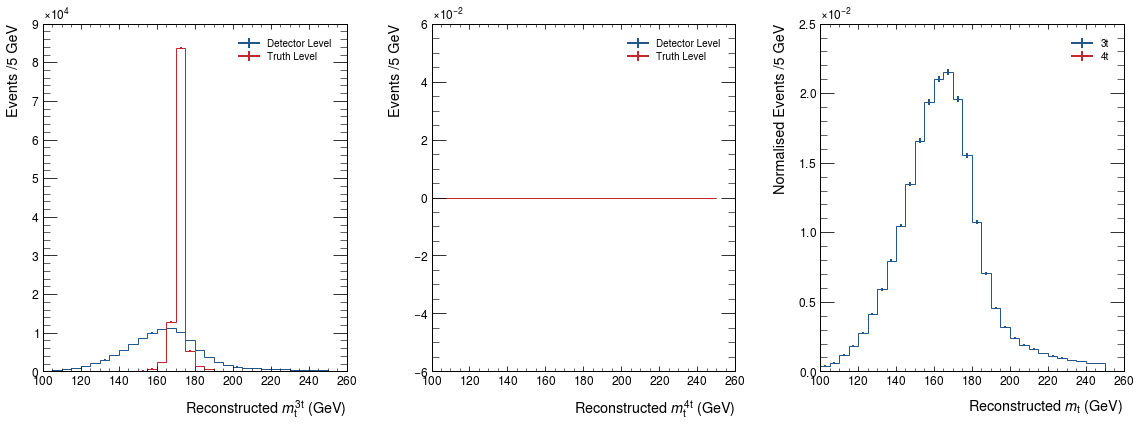

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (19,6))
histogram([ak.flatten(fm_reco_tops_3t_0L).m,tm_full_reco_tops_4t_0L.m], 30, ['3t', '4t'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[0].set_xlabel(r'Reconstructed $m_\mathrm{t}^{3\mathrm{t}}$ (GeV)')
histogram([tm_full_reco_tops_4t_0L.m, tm_full_truth_tops_4t_0L.m], 30, ['Detector Level', 'Truth Level'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
histogram([ak.flatten(fm_reco_tops_3t_0L).m,ak.flatten(fm_truth_tops_3t_0L).m], 30, ['Detector Level', 'Truth Level'], ax[0], density = False, x_units='GeV', print_peak=True, set_range=(100,250))
ax[1].set_xlabel(r'Reconstructed $m_\mathrm{t}^{4\mathrm{t}}$ (GeV)')
ax[2].set_xlabel(r'Reconstructed $m_\mathrm{t}$ (GeV)')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[2].legend()
plt.subplots_adjust(hspace=0.25, wspace=0.28)
plt.savefig('3t_4t_comparison.png', dpi=300)
plt.show()


In [21]:
fm_truth_tops_4t_0L

<MomentumArray4D [] type='0 * var * Momentum4D[t: float32, z: float32, x: f...'>

Peak bin center for $t_1$: 1666666666.67 GeV
Peak bin center for $t_2$: 1666666666.67 GeV
Peak bin center for $t_3$: 1666666666.67 GeV
Peak bin center for $t_4$: 1666666666.67 GeV
Peak bin center for $t_1$: 1666666666.67 GeV
Peak bin center for $t_2$: 1666666666.67 GeV
Peak bin center for $t_3$: 1666666666.67 GeV
Peak bin center for $t_4$: 1666666666.67 GeV
Peak bin center for Reco Tops: 4.17 GeV
Peak bin center for Truth Tops: 4.17 GeV


/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:22: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step', color = colours[i])
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:24: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:25: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:22: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax

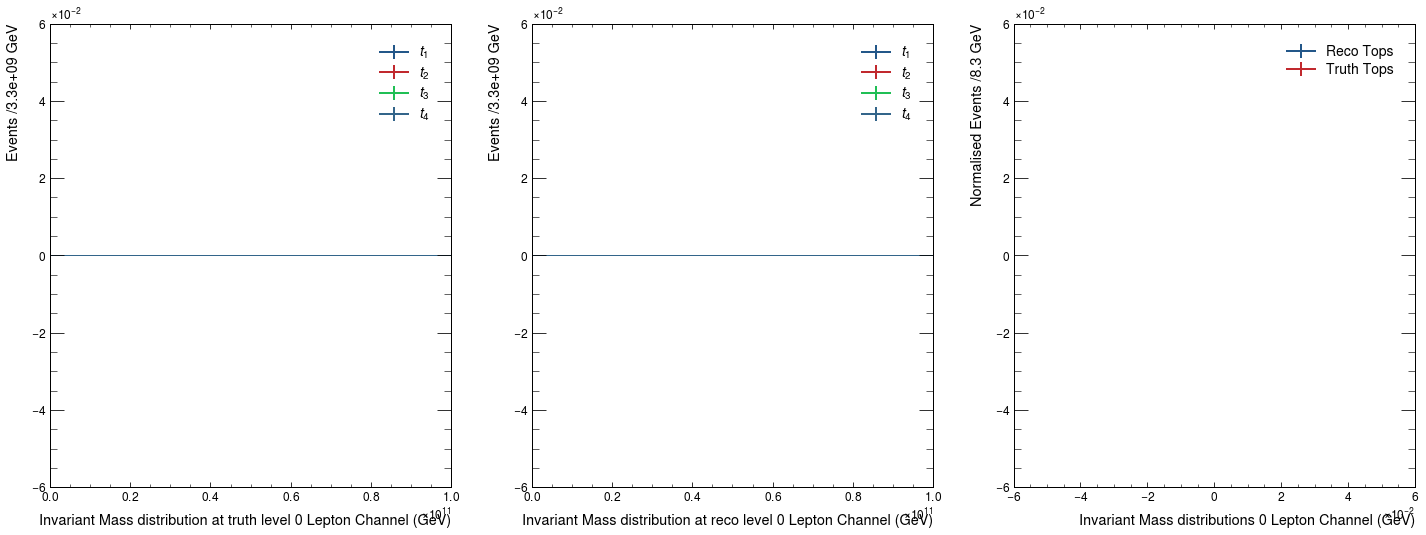

Peak bin center for $t_1$: 102.50 GeV
Peak bin center for $t_2$: 102.50 GeV
Peak bin center for $t_3$: 102.50 GeV
Peak bin center for $t_1$: 102.50 GeV
Peak bin center for $t_2$: 102.50 GeV
Peak bin center for $t_3$: 102.50 GeV
Peak bin center for Reco Tops: 102.50 GeV
Peak bin center for Truth Tops: 102.50 GeV


/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:22: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step', color = colours[i])
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:24: RuntimeWarning: invalid value encountered in divide
  counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:25: RuntimeWarning: invalid value encountered in divide
  errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))
/var/folders/cd/zr4yhmsd7fb_nt3cc7smgf080000gn/T/ipykernel_33719/2598929965.py:22: RuntimeWarning: invalid value encountered in divide
  if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax

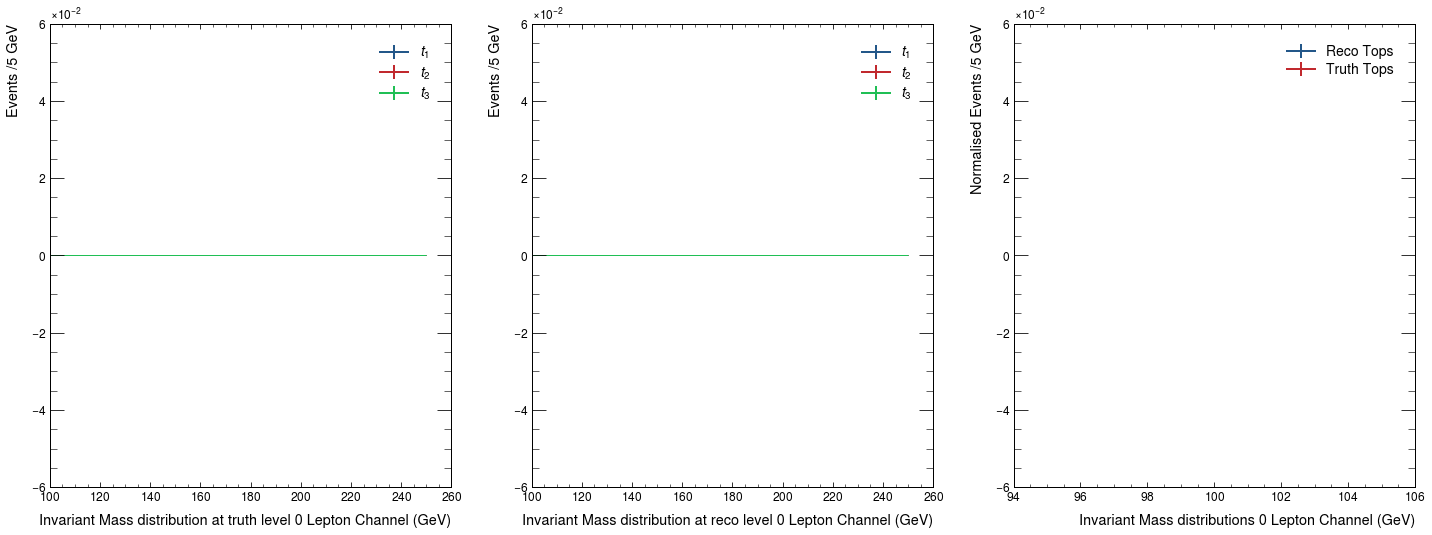

Peak bin center for $t_1$: 170.50 GeV
Peak bin center for $t_2$: 173.50 GeV
Peak bin center for $t_1$: 157.50 GeV
Peak bin center for $t_2$: 147.50 GeV
Peak bin center for Reco Tops: 157.50 GeV
Peak bin center for Truth Tops: 172.50 GeV


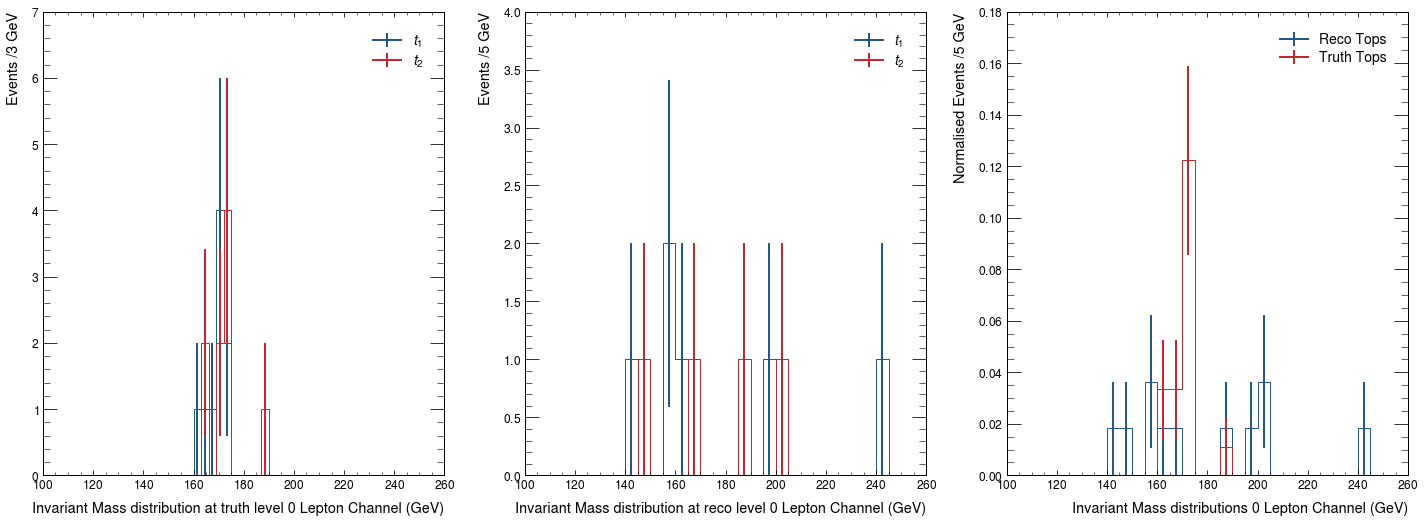

Peak bin center for truth tops: 170.00 GeV
Peak bin center for reco tops: 170.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 175.00 GeV


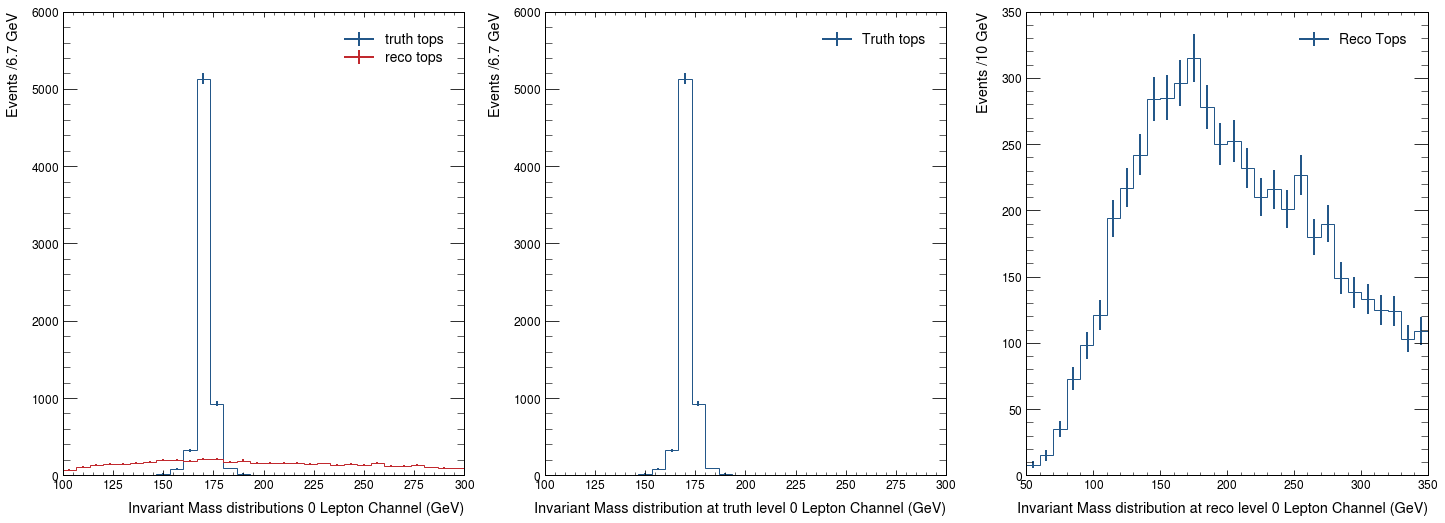

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_4t_0L[:,0].m, fm_truth_tops_4t_0L[:,1].m, fm_truth_tops_4t_0L[:,2].m, fm_truth_tops_4t_0L[:,3].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(0,1000e8), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([fm_reco_tops_4t_0L[:,0].m, fm_reco_tops_4t_0L[:,1].m, fm_reco_tops_4t_0L[:,2].m, fm_reco_tops_4t_0L[:,3].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(0,1000e8), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_4t_0L.m,fm_full_truth_tops_4t_0L.m], 30, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(0,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([tm_truth_tops_4t_0L[:,0].m, tm_truth_tops_4t_0L[:,1].m, tm_truth_tops_4t_0L[:,2].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([tm_reco_tops_4t_0L[:,0].m, tm_reco_tops_4t_0L[:,1].m, tm_reco_tops_4t_0L[:,2].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
histogram([tm_full_reco_tops_4t_0L.m,tm_full_truth_tops_4t_0L.m], 30, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_4t_0L[:,0].m, dm_truth_tops_4t_0L[:,1].m], 50, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([dm_reco_tops_4t_0L[:,0].m, dm_reco_tops_4t_0L[:,1].m], 30, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_4t_0L.m,dm_full_truth_tops_4t_0L.m], 30, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_4t_0L).m,ak.flatten(sm_reco_tops_4t_0L).m], 30, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_4t_0L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_4t_0L).m], 30, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 163.75 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


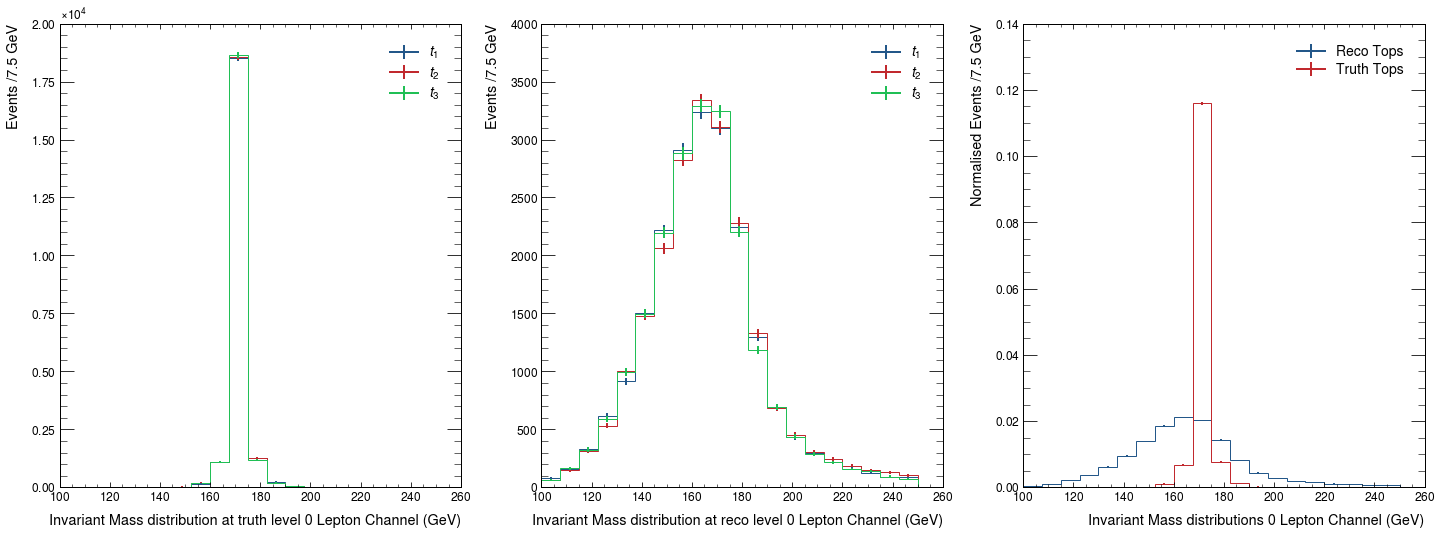

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_1$: 163.75 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


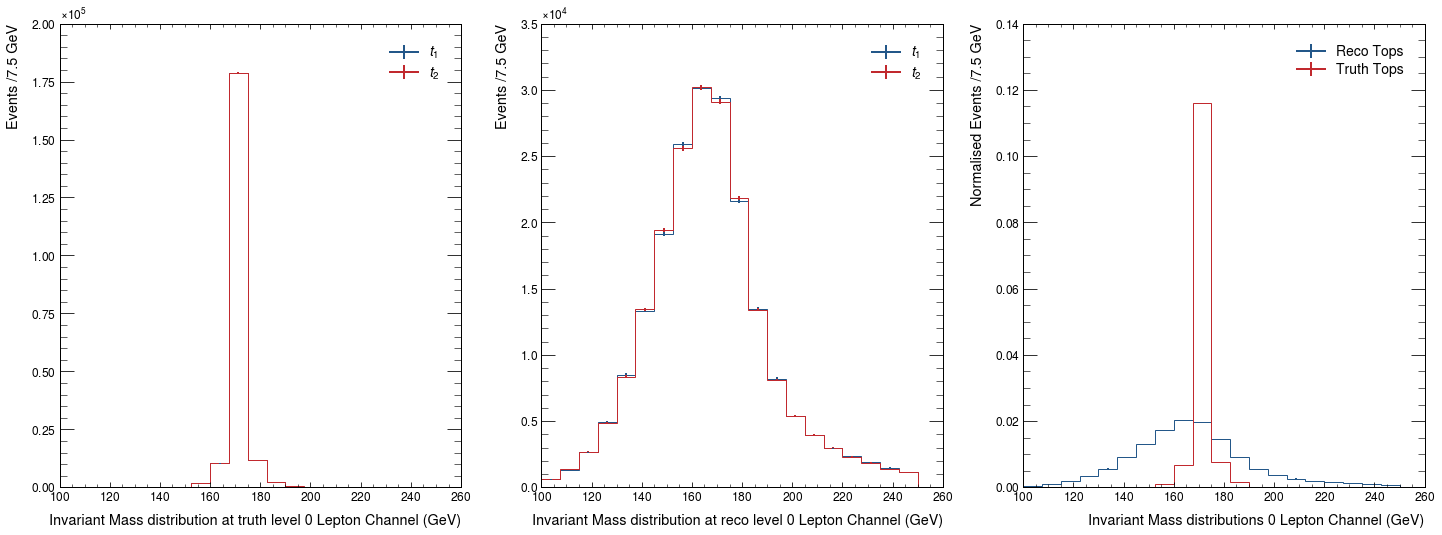

Peak bin center for truth tops: 175.00 GeV
Peak bin center for reco tops: 165.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 167.00 GeV


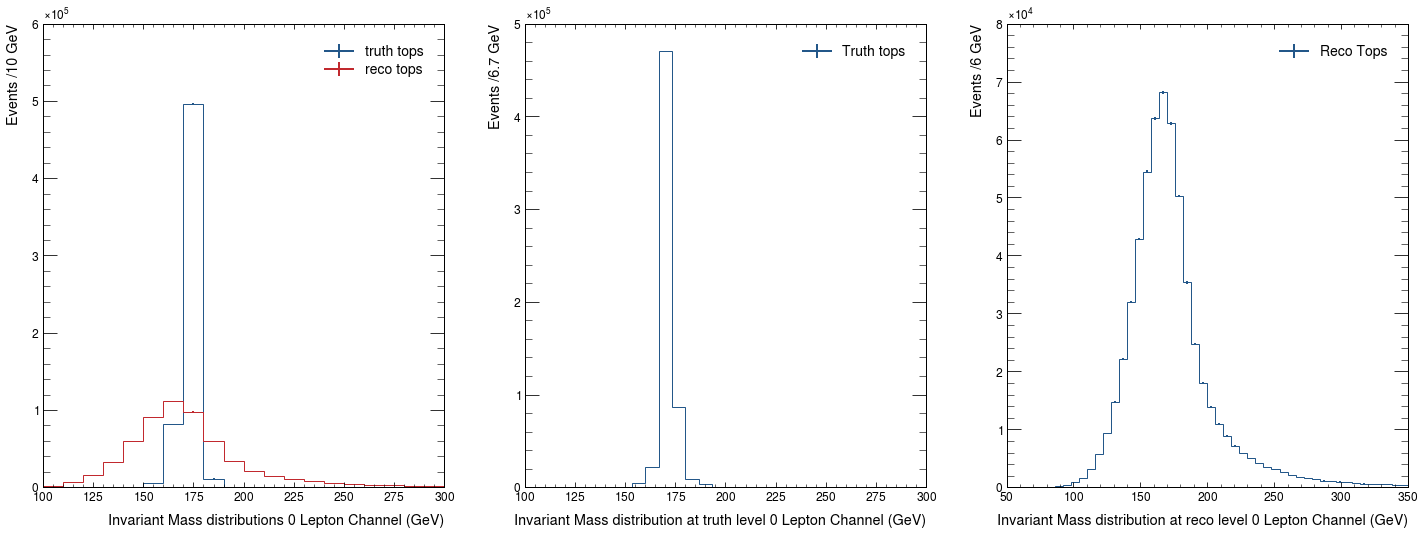

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tW_0L[:,0].m, fm_truth_tops_3tW_0L[:,1].m, fm_truth_tops_3tW_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([fm_reco_tops_3tW_0L[:,0].m, fm_reco_tops_3tW_0L[:,1].m, fm_reco_tops_3tW_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_3tW_0L.m,fm_full_truth_tops_3tW_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_3tW_0L[:,0].m, dm_truth_tops_3tW_0L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([dm_reco_tops_3tW_0L[:,0].m, dm_reco_tops_3tW_0L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_3tW_0L.m,dm_full_truth_tops_3tW_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_3tW_0L).m,ak.flatten(sm_reco_tops_3tW_0L).m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_3tW_0L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_3tW_0L).m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 163.75 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


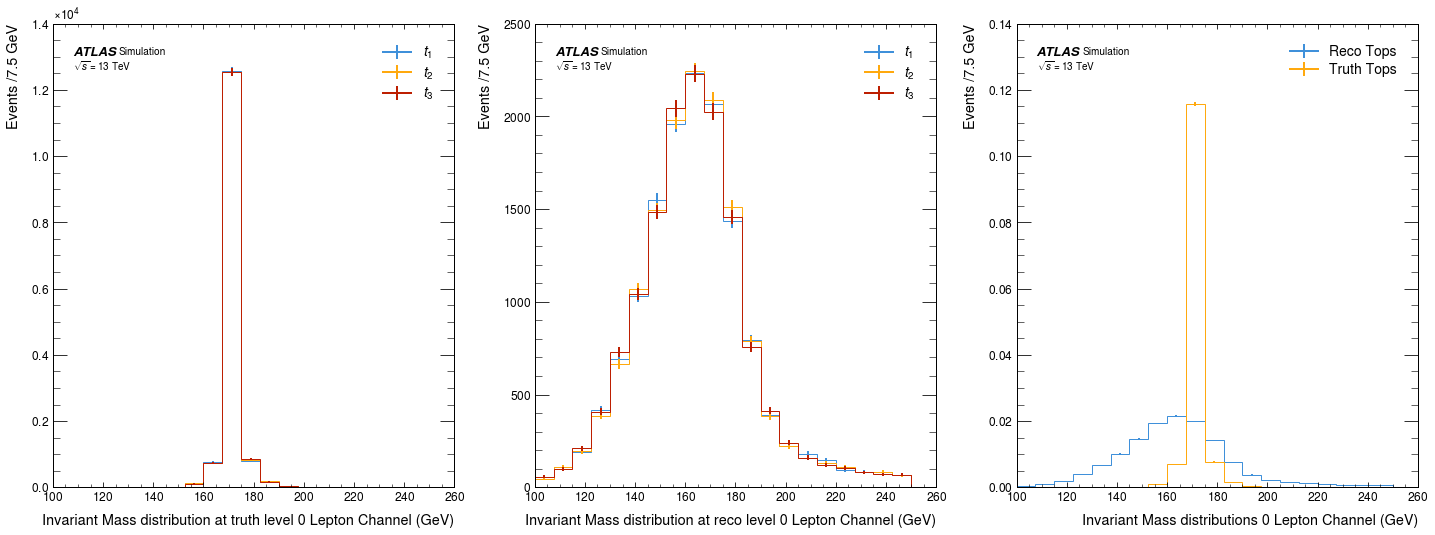

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_1$: 163.75 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


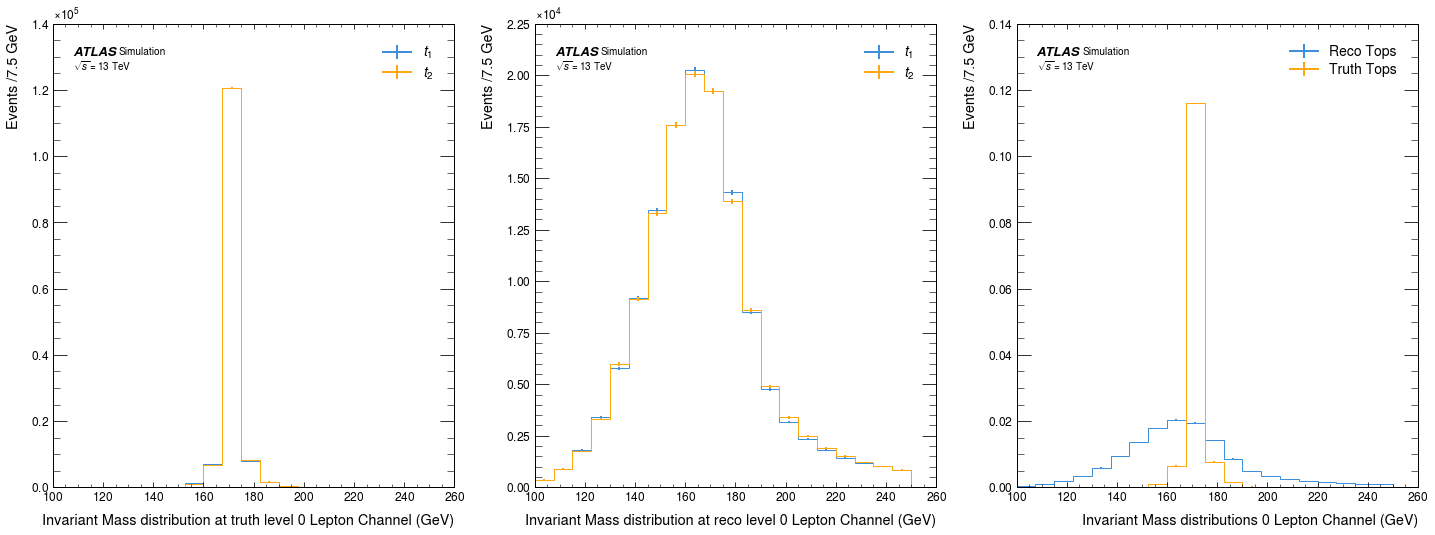

Peak bin center for truth tops: 175.00 GeV
Peak bin center for reco tops: 165.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 167.00 GeV


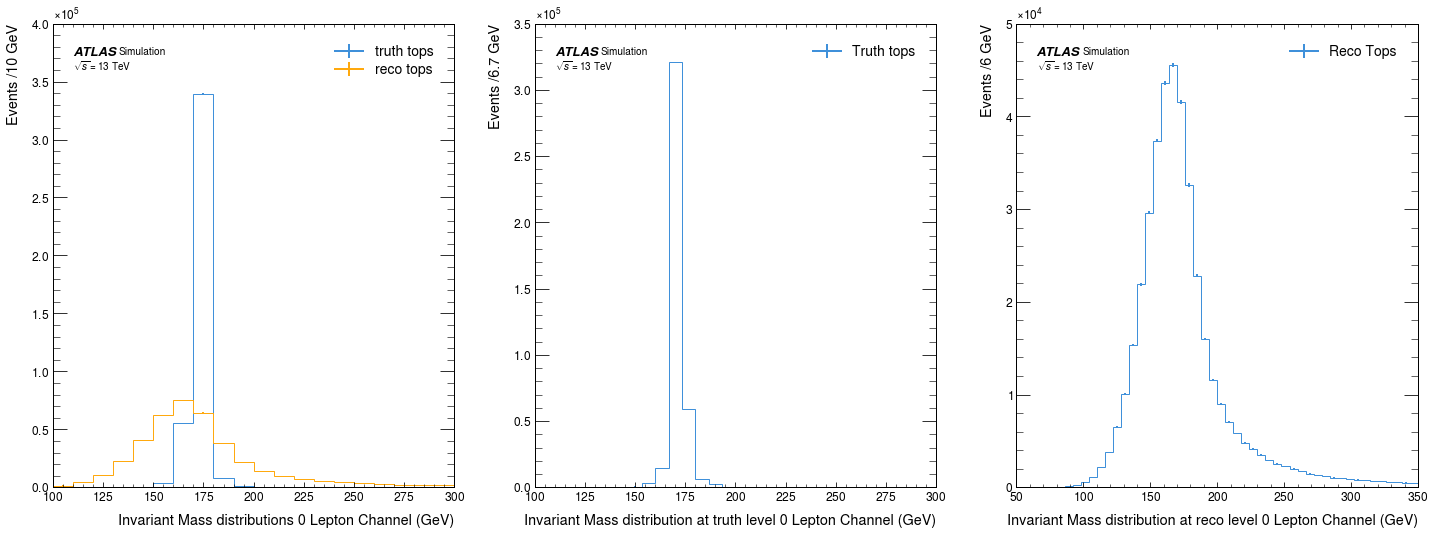

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tj_0L[:,0].m, fm_truth_tops_3tj_0L[:,1].m, fm_truth_tops_3tj_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([fm_reco_tops_3tj_0L[:,0].m, fm_reco_tops_3tj_0L[:,1].m, fm_reco_tops_3tj_0L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_3tj_0L.m,fm_full_truth_tops_3tj_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_3tj_0L[:,0].m, dm_truth_tops_3tj_0L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([dm_reco_tops_3tj_0L[:,0].m, dm_reco_tops_3tj_0L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_3tj_0L.m,dm_full_truth_tops_3tj_0L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_3tj_0L).m,ak.flatten(sm_reco_tops_3tj_0L).m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 0 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_3tj_0L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 0 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_3tj_0L).m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 0 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

### 1 Lepton Channel

In [45]:
hep.style.use(hep.style.ATLAS)

NameError: name 'fm_reco_tops_3t_1L' is not defined

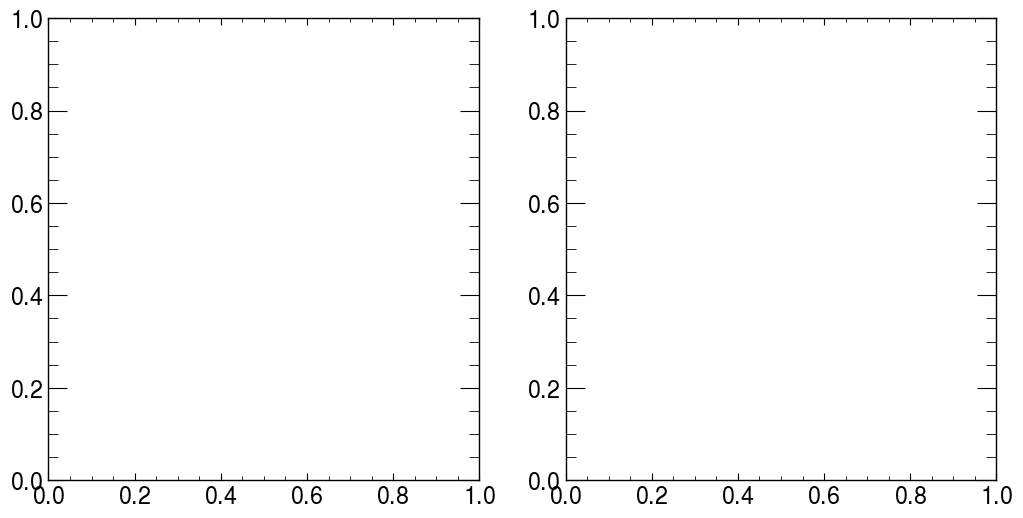

In [69]:


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot histograms
histogram([fm_reco_tops_3t_1L[:,0].m, fm_reco_tops_3t_1L[:,1].m, fm_reco_tops_3t_1L[:,2].m], 30, [r't$_{\mathrm{lep}}$', r't$_{\mathrm{j}1}$', r't$_{\mathrm{j}2}$'], ax[0], density=True, x_units='GeV', set_range=(100, 250), print_peak=True)
ax[0].set_xlabel(r'Reconstructed $m_t^{3t}$ (GeV)')


bw_4t = histogram([tm_reco_tops_4t_1L[:,0].m, tm_reco_tops_4t_1L[:,1].m, tm_reco_tops_4t_1L[:,2].m], 30, [r't$_{\mathrm{lep}}$', r't$_{\mathrm{j}1}$', r't$_{\mathrm{j}2}$'], ax[1], density=True, x_units='GeV', set_range=(100, 250), print_peak=True)
ax[1].set_xlabel(r'Reconstructed $m_t^{4t}$ (GeV)')
ax[0].legend(fontsize=16)

plt.subplots_adjust(hspace=0.25, wspace=0.3)
plt.savefig('3t_4t_comparison_1L.png', dpi=300)
plt.show()

In [29]:
hep.style.use(hep.style.ROOT)

Peak bin center for $t_1$: 172.50 GeV
Peak bin center for $t_2$: 172.50 GeV
Peak bin center for $t_3$: 172.50 GeV
Peak bin center for $t_4$: 172.50 GeV
Peak bin center for $t_1$: 172.50 GeV
Peak bin center for $t_2$: 162.50 GeV
Peak bin center for $t_3$: 162.50 GeV
Peak bin center for $t_4$: 172.50 GeV
Peak bin center for Reco Tops: 167.50 GeV
Peak bin center for Truth Tops: 172.50 GeV


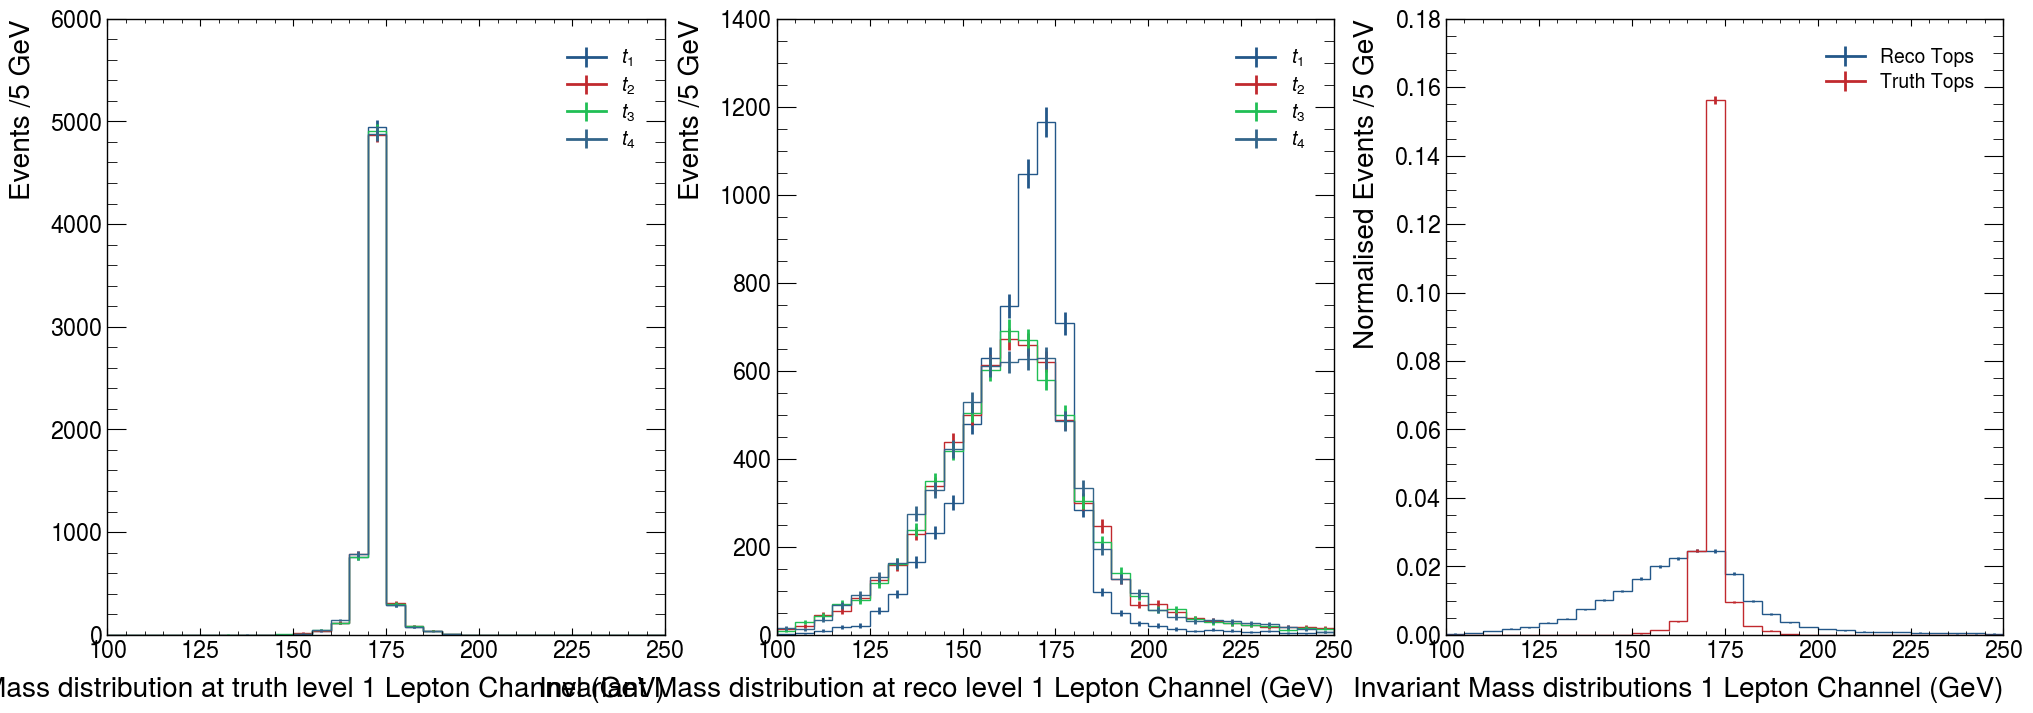

Peak bin center for $t_1$: 167.50 GeV
Peak bin center for $t_2$: 162.50 GeV
Peak bin center for $t_3$: 167.50 GeV
Peak bin center for $t_1$: 167.50 GeV
Peak bin center for $t_2$: 167.50 GeV
Peak bin center for $t_3$: 167.50 GeV
Peak bin center for $t_1$: 162.50 GeV
Peak bin center for $t_2$: 167.50 GeV
Peak bin center for $t_3$: 167.50 GeV


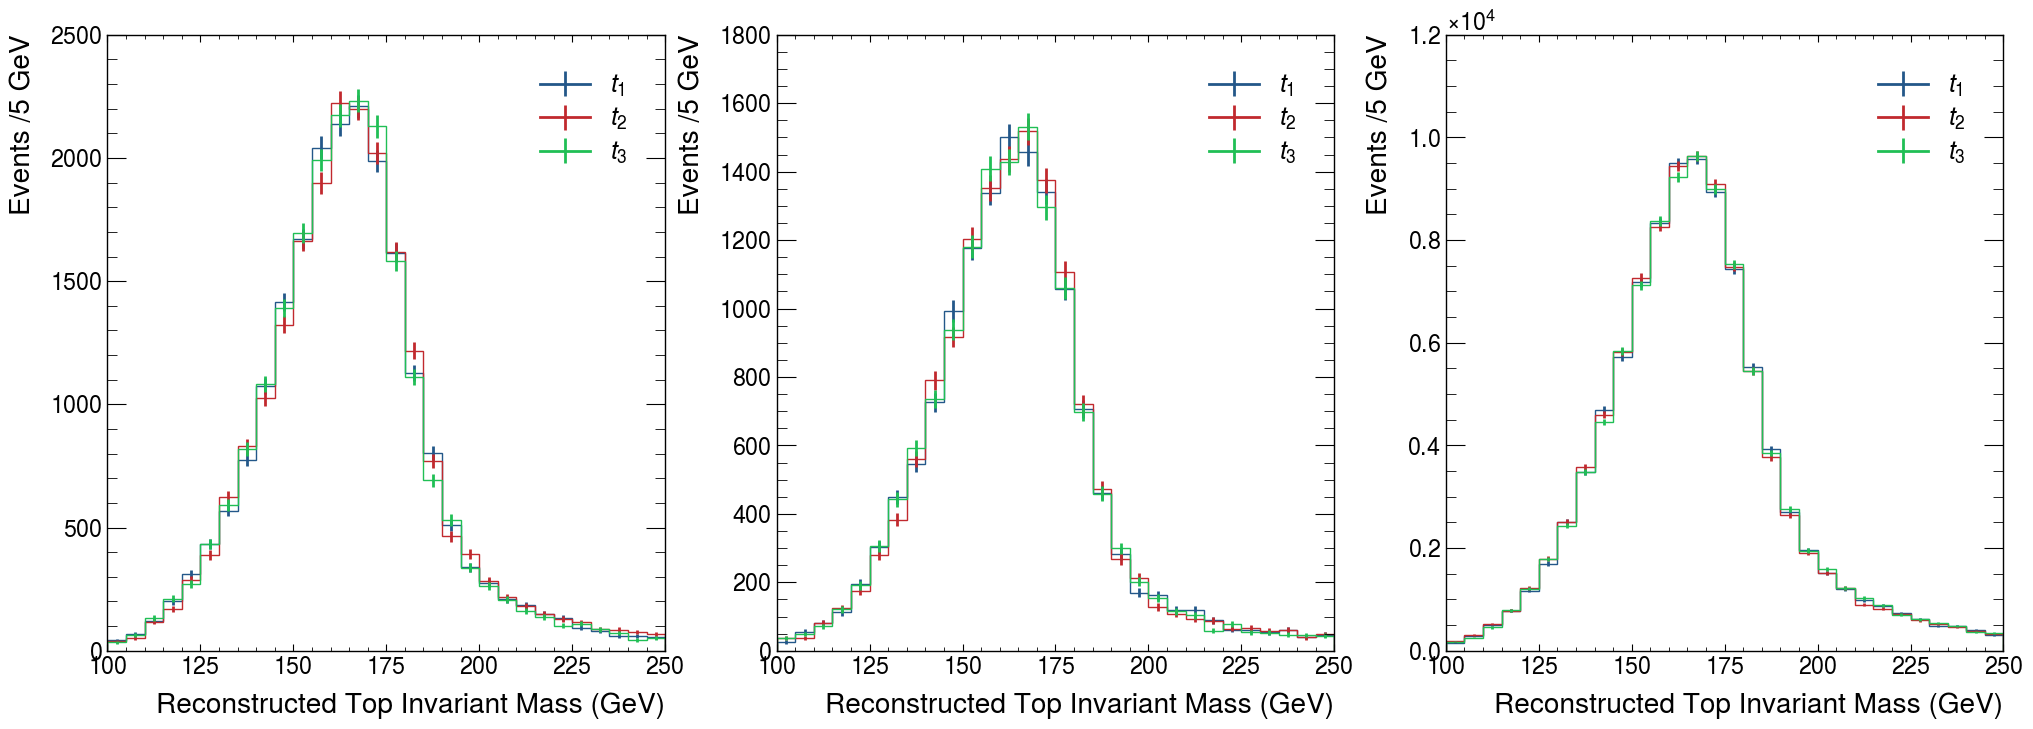

Peak bin center for $t_1$: 172.50 GeV
Peak bin center for $t_2$: 172.50 GeV
Peak bin center for $t_1$: 172.50 GeV
Peak bin center for $t_2$: 167.50 GeV
Peak bin center for Reco Tops: 167.50 GeV
Peak bin center for Truth Tops: 172.50 GeV


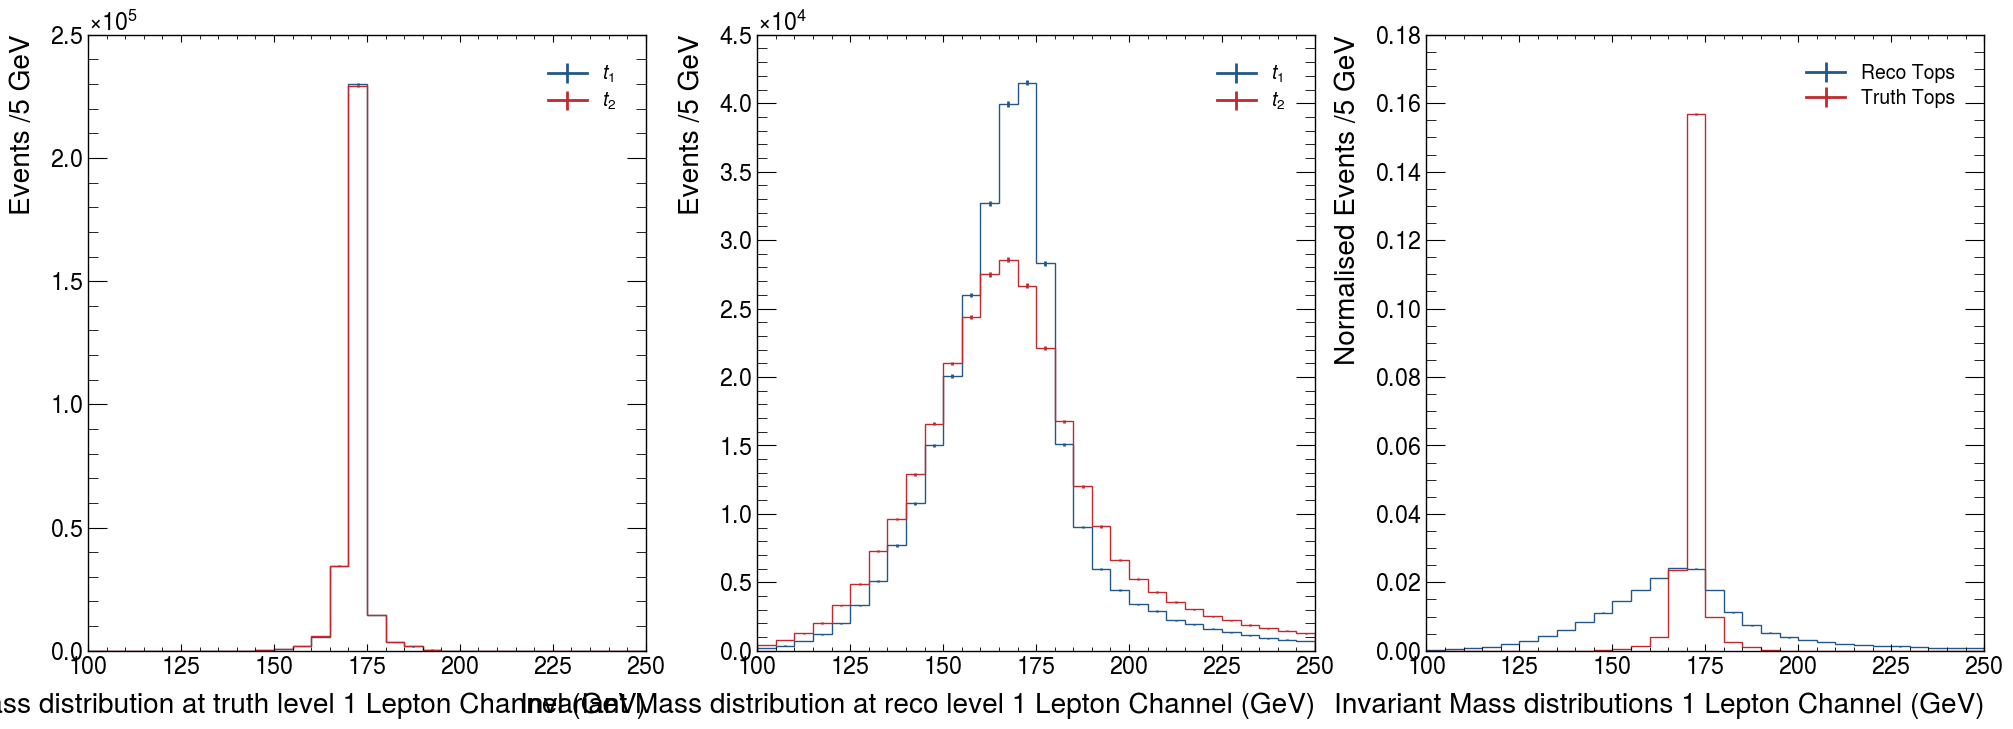

Peak bin center for truth tops: 170.00 GeV
Peak bin center for reco tops: 170.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 174.00 GeV


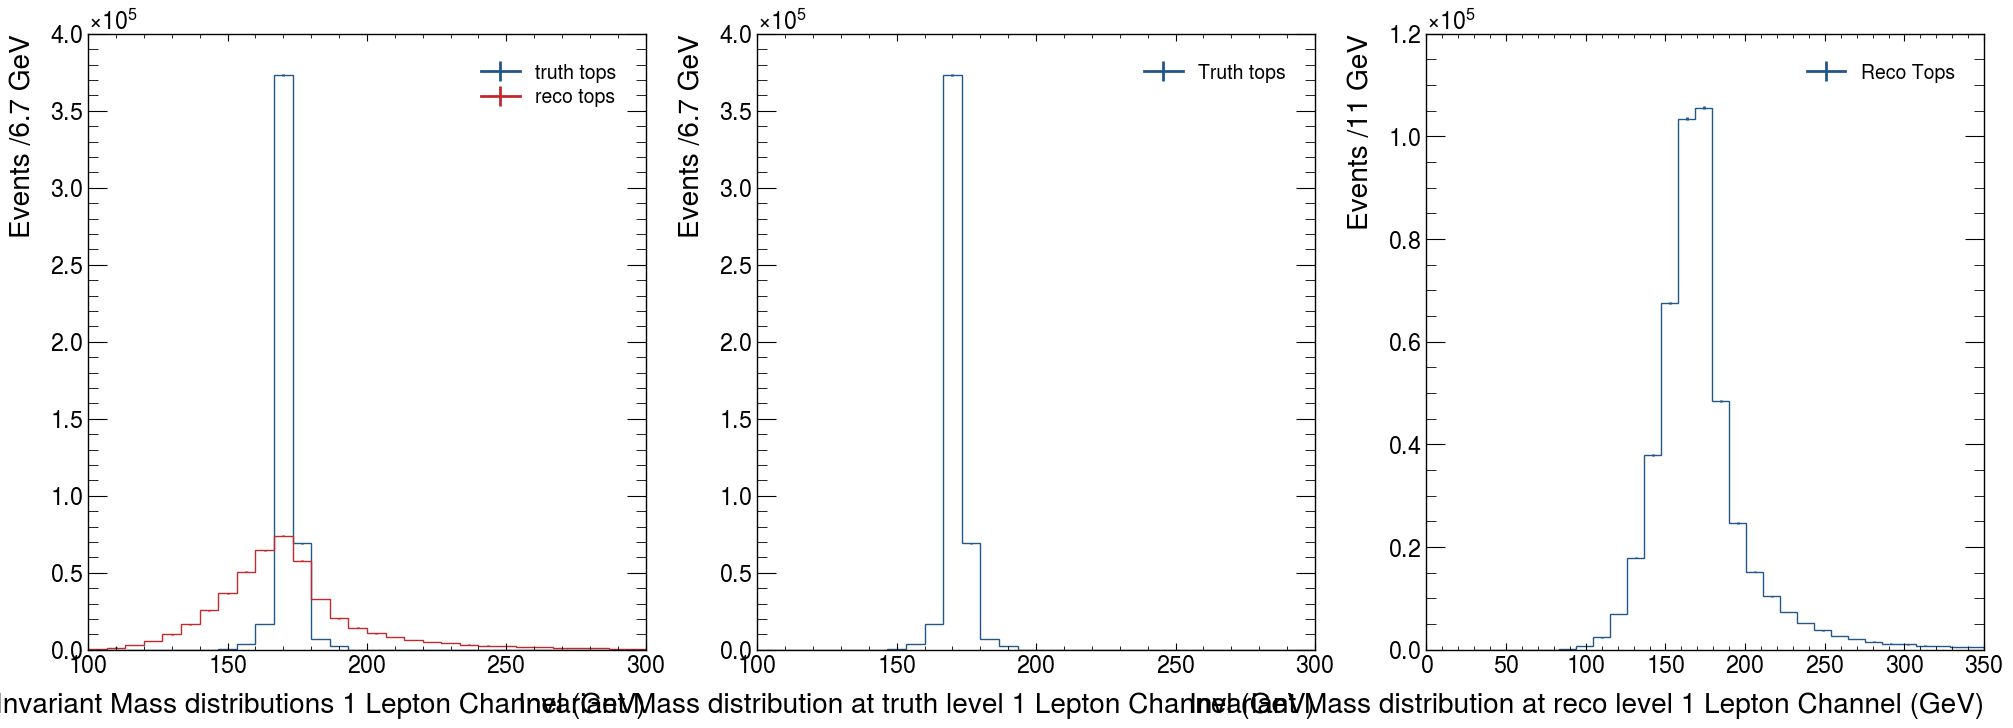

: 

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_4t_1L[:,0].m, fm_truth_tops_4t_1L[:,1].m, fm_truth_tops_4t_1L[:,2].m, fm_truth_tops_4t_1L[:,3].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([fm_reco_tops_4t_1L[:,0].m, fm_reco_tops_4t_1L[:,1].m, fm_reco_tops_4t_1L[:,2].m, fm_reco_tops_4t_1L[:,3].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_4t_1L.m,fm_full_truth_tops_4t_1L.m], 30, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_reco_tops_3tW_0L[:,0].m, fm_reco_tops_3tW_0L[:,1].m, fm_reco_tops_3tW_0L[:,2].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Reconstructed Top Invariant Mass (GeV)')
histogram([tm_reco_tops_4t_0L[:,0].m, tm_reco_tops_4t_0L[:,1].m, tm_reco_tops_4t_0L[:,2].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[2], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Reconstructed Top Invariant Mass (GeV)')
histogram([fm_reco_tops_3tj_0L[:,0].m, fm_reco_tops_3tj_0L[:,1].m, fm_reco_tops_3tj_0L[:,2].m], 30, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[2].set_xlabel(r'Reconstructed Top Invariant Mass (GeV)')
ax[0].legend(fontsize=18)
ax[1].legend(fontsize=18)
ax[2].legend(fontsize=18)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_4t_1L[:,0].m, dm_truth_tops_4t_1L[:,1].m], 30, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([dm_reco_tops_4t_1L[:,0].m, dm_reco_tops_4t_1L[:,1].m], 30, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_4t_1L.m,dm_full_truth_tops_4t_1L.m], 30, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_4t_1L).m,ak.flatten(sm_reco_tops_4t_1L).m], 30, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_4t_1L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_4t_1L).m], 30, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(30,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 171.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


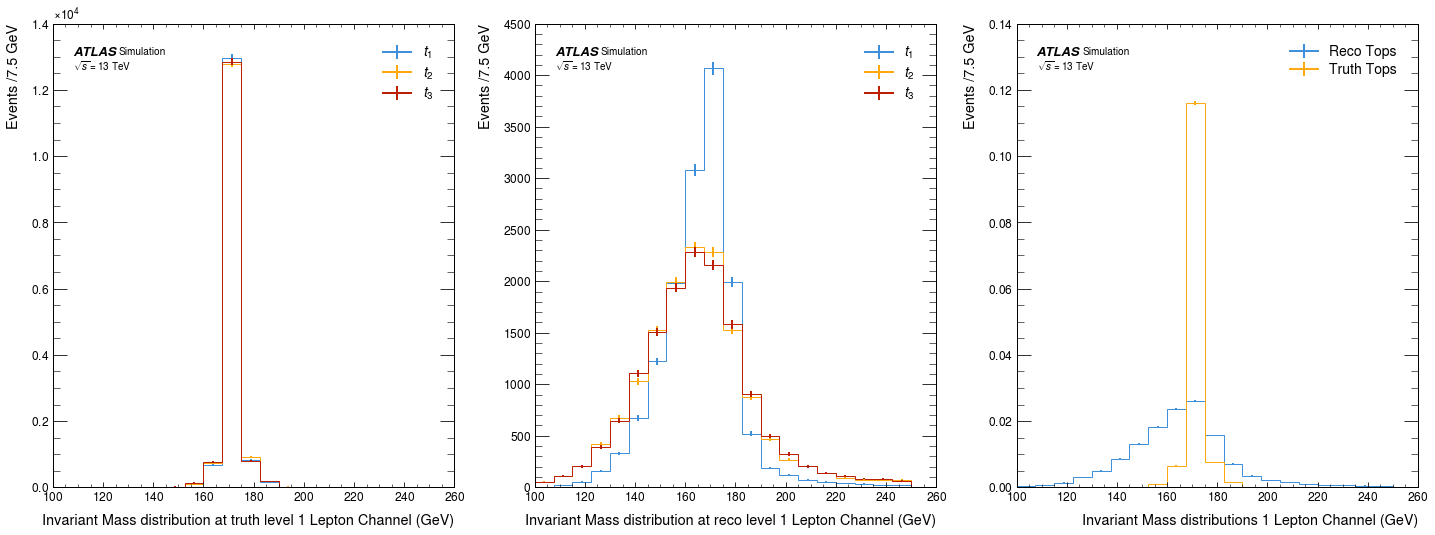

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for Reco Tops: 171.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


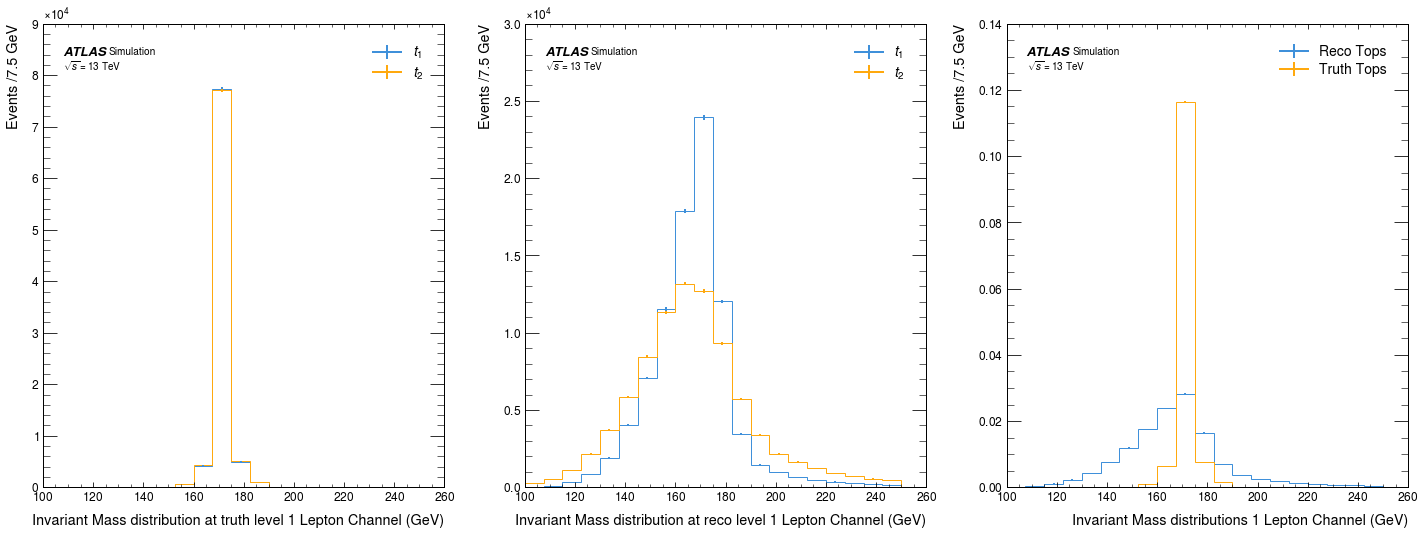

Peak bin center for truth tops: 175.00 GeV
Peak bin center for reco tops: 165.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 173.00 GeV


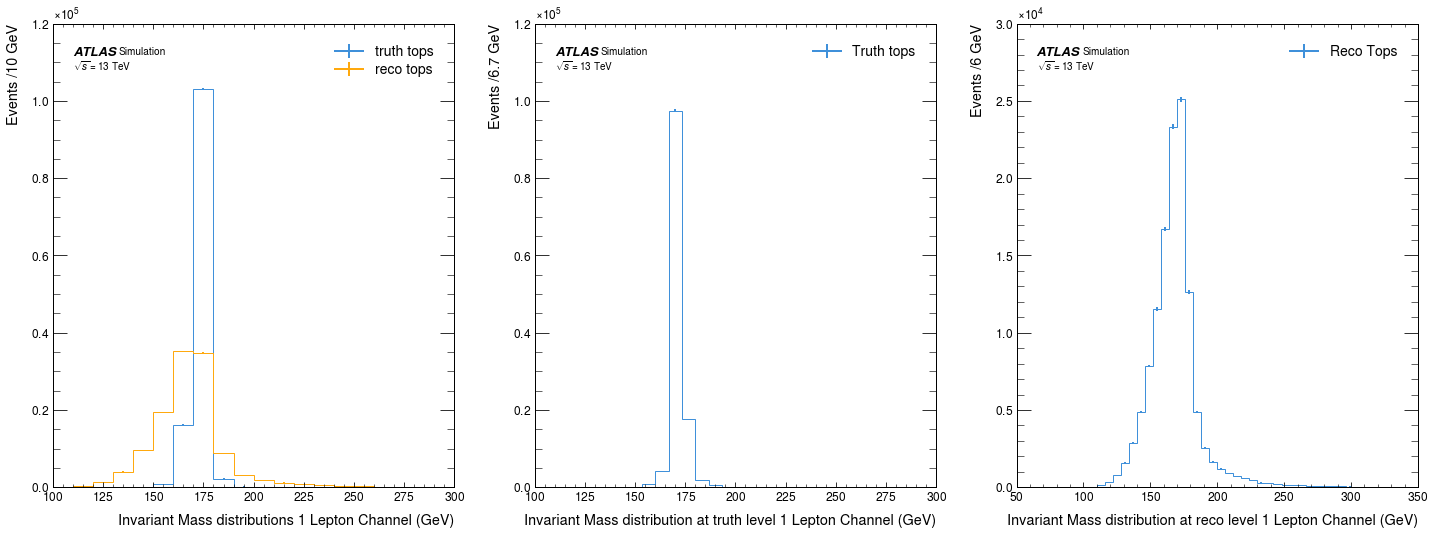

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tW_1L[:,0].m, fm_truth_tops_3tW_1L[:,1].m, fm_truth_tops_3tW_1L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([fm_reco_tops_3tW_1L[:,0].m, fm_reco_tops_3tW_1L[:,1].m, fm_reco_tops_3tW_1L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_3tW_1L.m,fm_full_truth_tops_3tW_1L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_3tW_1L[:,0].m, dm_truth_tops_3tW_1L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([dm_reco_tops_3tW_1L[:,0].m, dm_reco_tops_3tW_1L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_3tW_1L.m,dm_full_truth_tops_3tW_1L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_3tW_1L).m,ak.flatten(sm_reco_tops_3tW_1L).m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_3tW_1L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_3tW_1L).m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 171.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


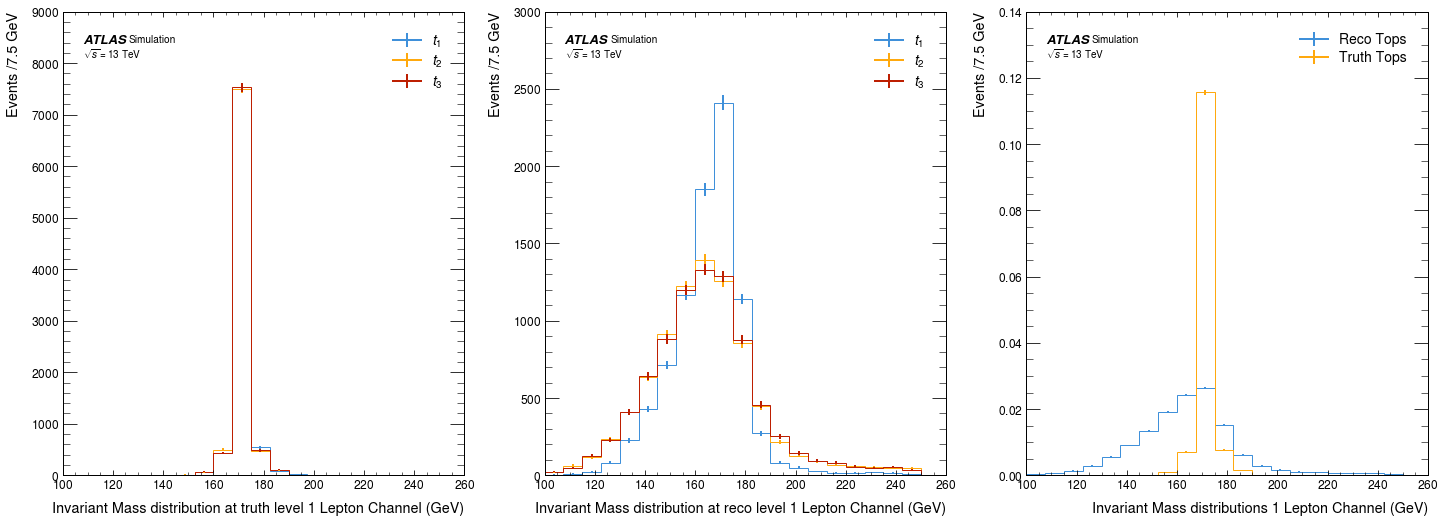

Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_1$: 171.25 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for Reco Tops: 171.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


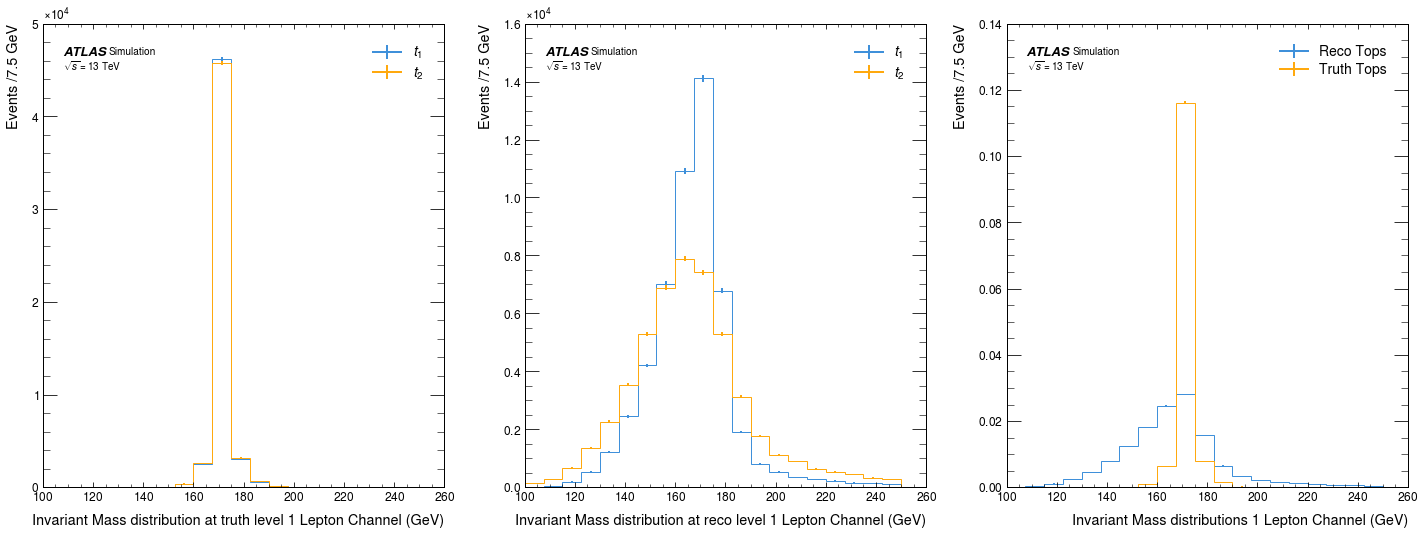

Peak bin center for truth tops: 175.00 GeV
Peak bin center for reco tops: 165.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 173.00 GeV


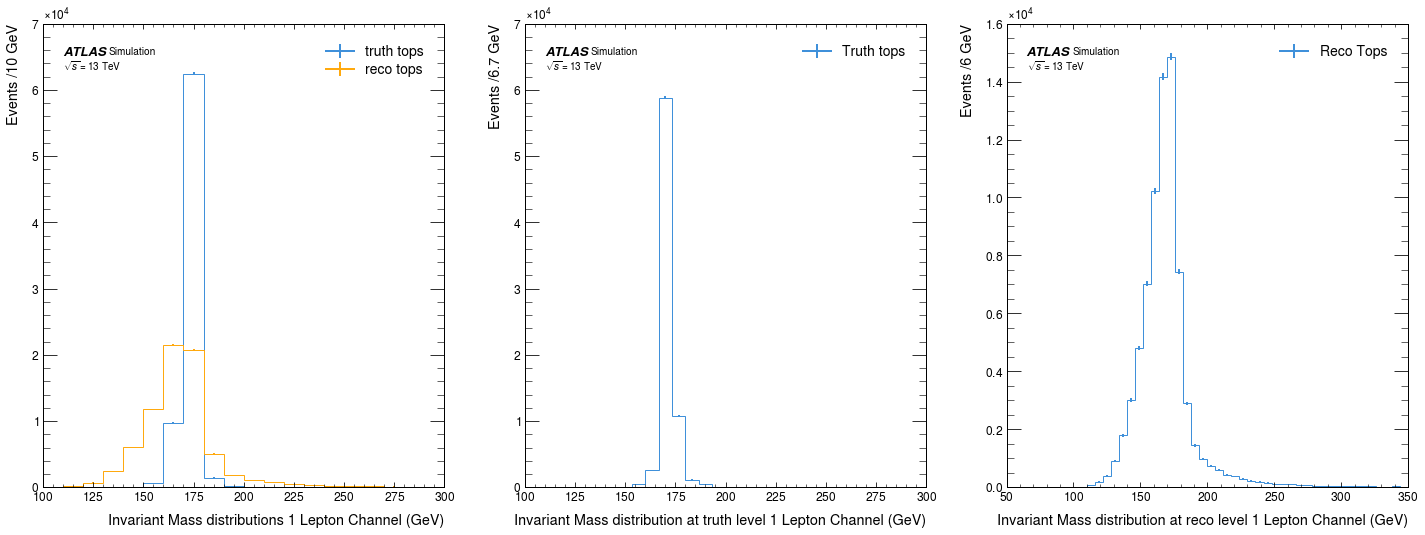

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tj_1L[:,0].m, fm_truth_tops_3tj_1L[:,1].m, fm_truth_tops_3tj_1L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([fm_reco_tops_3tj_1L[:,0].m, fm_reco_tops_3tj_1L[:,1].m, fm_reco_tops_3tj_1L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_3tj_1L.m,fm_full_truth_tops_3tj_1L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_3tj_1L[:,0].m, dm_truth_tops_3tj_1L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([dm_reco_tops_3tj_1L[:,0].m, dm_reco_tops_3tj_1L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_3tj_1L.m,dm_full_truth_tops_3tj_1L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_3tj_1L).m,ak.flatten(sm_reco_tops_3tj_1L).m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 1 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_3tj_1L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 1 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_3tj_1L).m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 1 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

### 2 Lepton Channel

Peak bin center for $t_1$: 111.25 GeV
Peak bin center for $t_2$: 111.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_4$: 171.25 GeV
Peak bin center for $t_1$: 103.75 GeV
Peak bin center for $t_2$: 103.75 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for $t_4$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


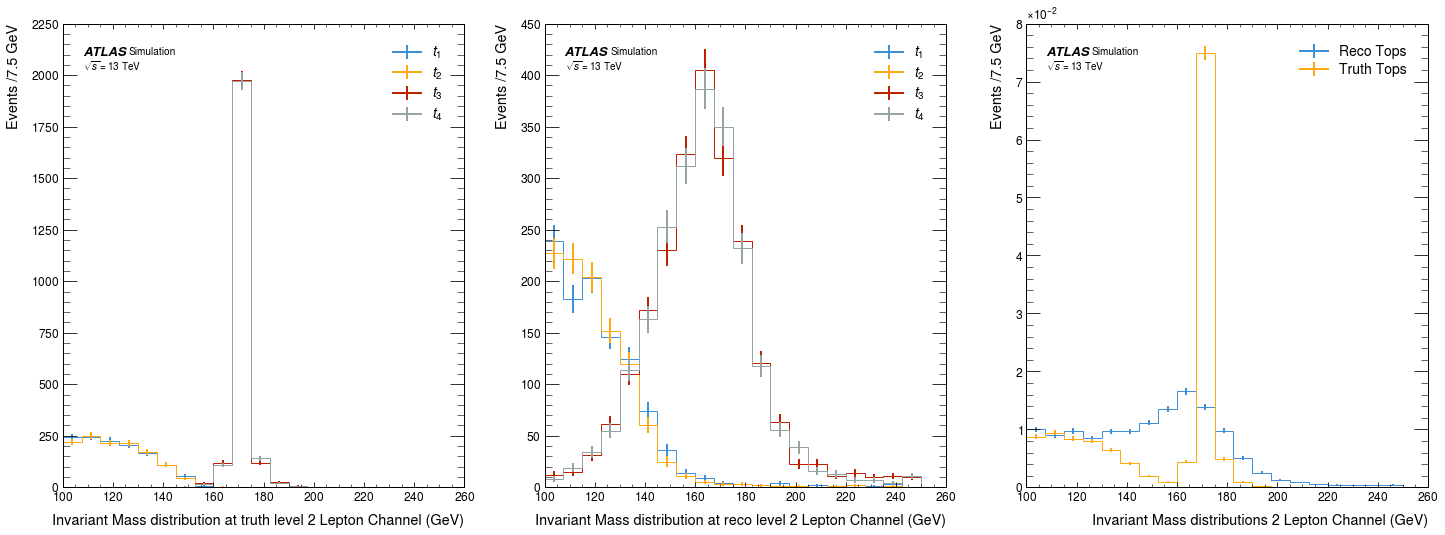

Peak bin center for $t_1$: 118.75 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 111.25 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


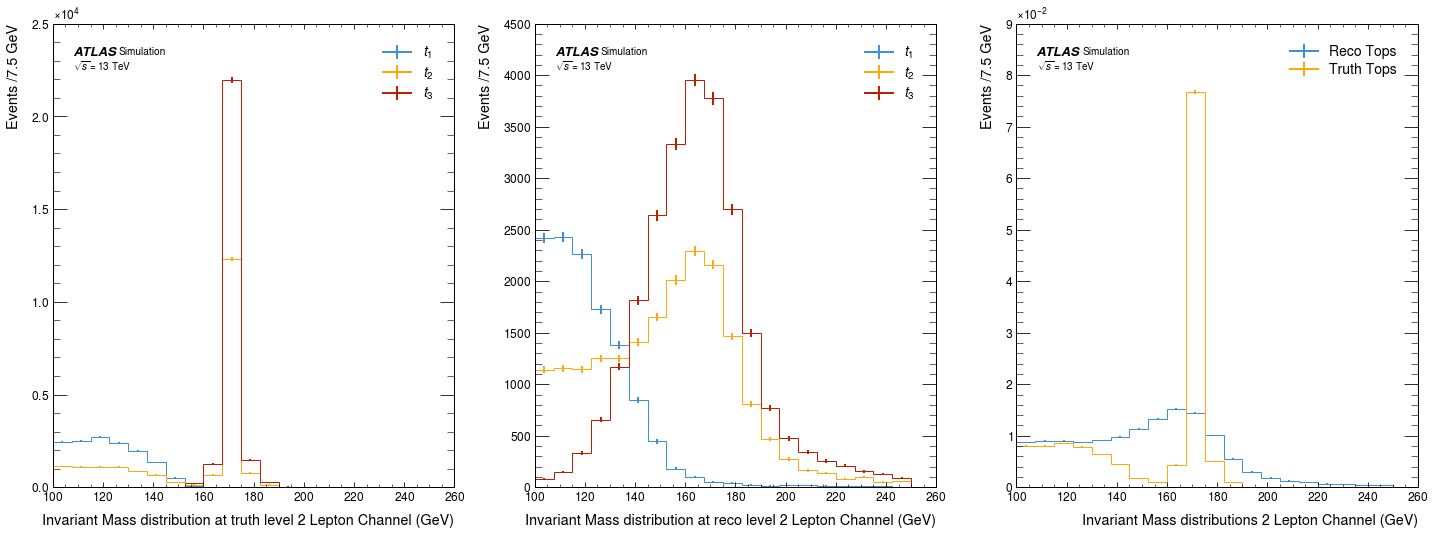

Peak bin center for $t_1$: 111.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_1$: 103.75 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for Reco Tops: 163.75 GeV
Peak bin center for Truth Tops: 171.25 GeV


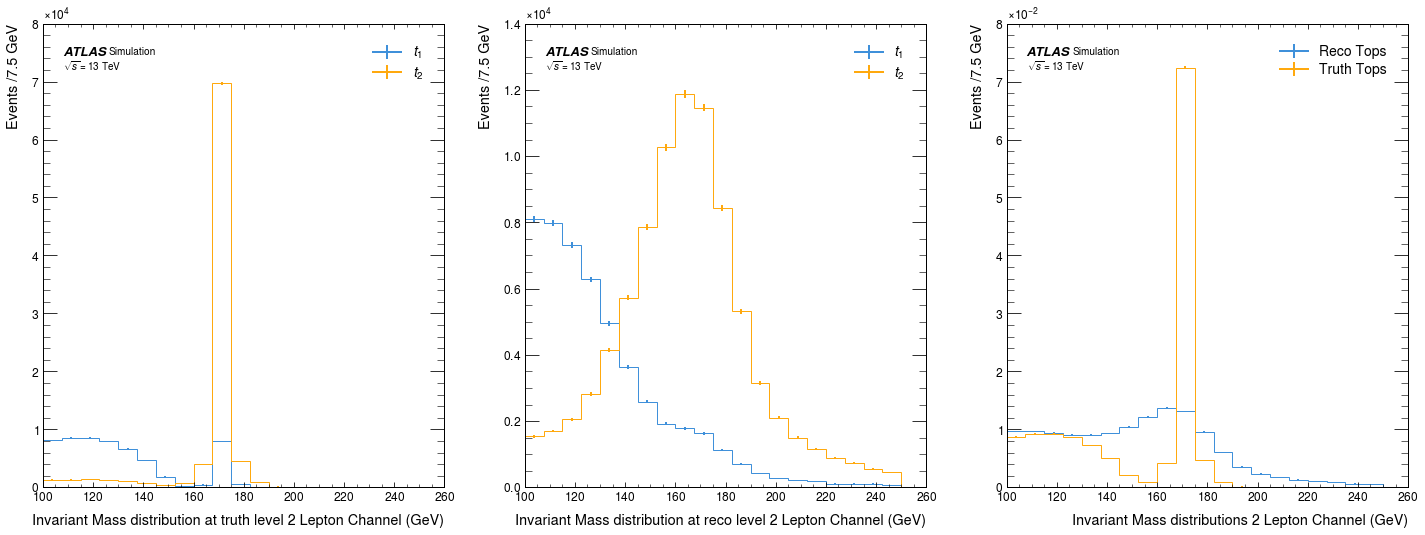

Peak bin center for truth tops: 175.00 GeV
Peak bin center for reco tops: 115.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 113.00 GeV


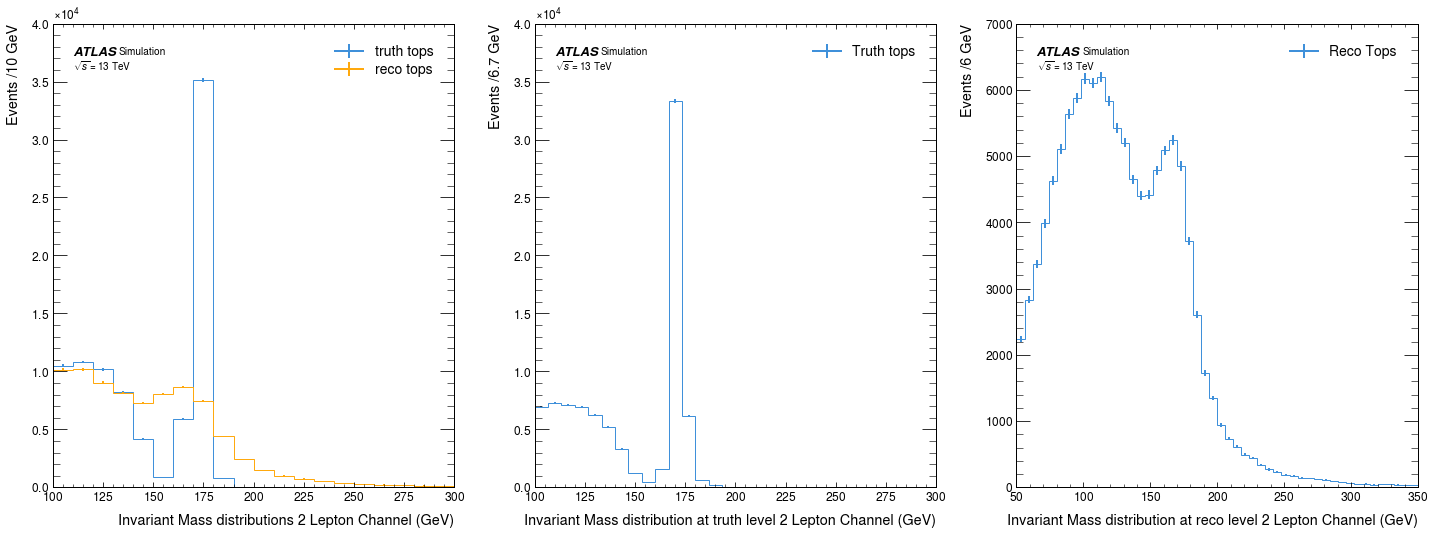

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_4t_2L[:,0].m, fm_truth_tops_4t_2L[:,1].m, fm_truth_tops_4t_2L[:,2].m, fm_truth_tops_4t_2L[:,3].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([fm_reco_tops_4t_2L[:,0].m, fm_reco_tops_4t_2L[:,1].m, fm_reco_tops_4t_2L[:,2].m, fm_reco_tops_4t_2L[:,3].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_4t_2L.m,fm_full_truth_tops_4t_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([tm_truth_tops_4t_2L[:,0].m, tm_truth_tops_4t_2L[:,1].m, tm_truth_tops_4t_2L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([tm_reco_tops_4t_2L[:,0].m, tm_reco_tops_4t_2L[:,1].m, tm_reco_tops_4t_2L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
histogram([tm_full_reco_tops_4t_2L.m,tm_full_truth_tops_4t_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_4t_2L[:,0].m, dm_truth_tops_4t_2L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([dm_reco_tops_4t_2L[:,0].m, dm_reco_tops_4t_2L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_4t_2L.m,dm_full_truth_tops_4t_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_4t_2L).m,ak.flatten(sm_reco_tops_4t_2L).m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_4t_2L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_4t_2L).m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

Peak bin center for $t_1$: 118.75 GeV
Peak bin center for $t_2$: 118.75 GeV
Peak bin center for $t_3$: 171.25 GeV
Peak bin center for $t_1$: 103.75 GeV
Peak bin center for $t_2$: 111.25 GeV
Peak bin center for $t_3$: 163.75 GeV
Peak bin center for Reco Tops: 111.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


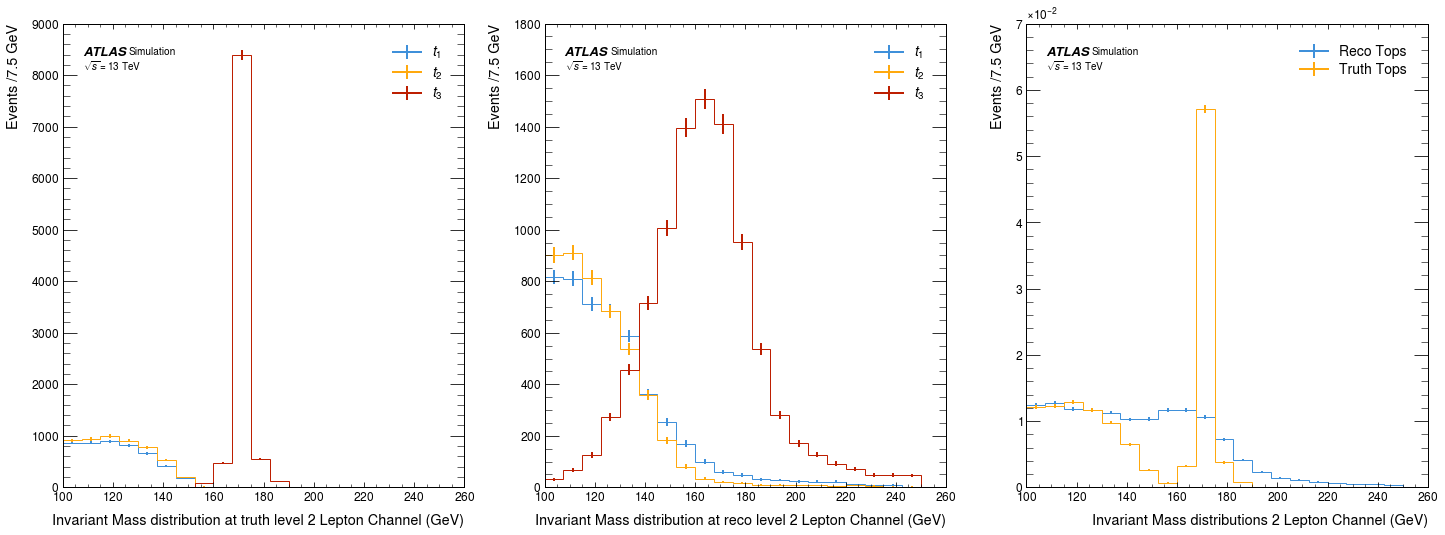

Peak bin center for $t_1$: 111.25 GeV
Peak bin center for $t_2$: 171.25 GeV
Peak bin center for $t_1$: 111.25 GeV
Peak bin center for $t_2$: 163.75 GeV
Peak bin center for Reco Tops: 111.25 GeV
Peak bin center for Truth Tops: 171.25 GeV


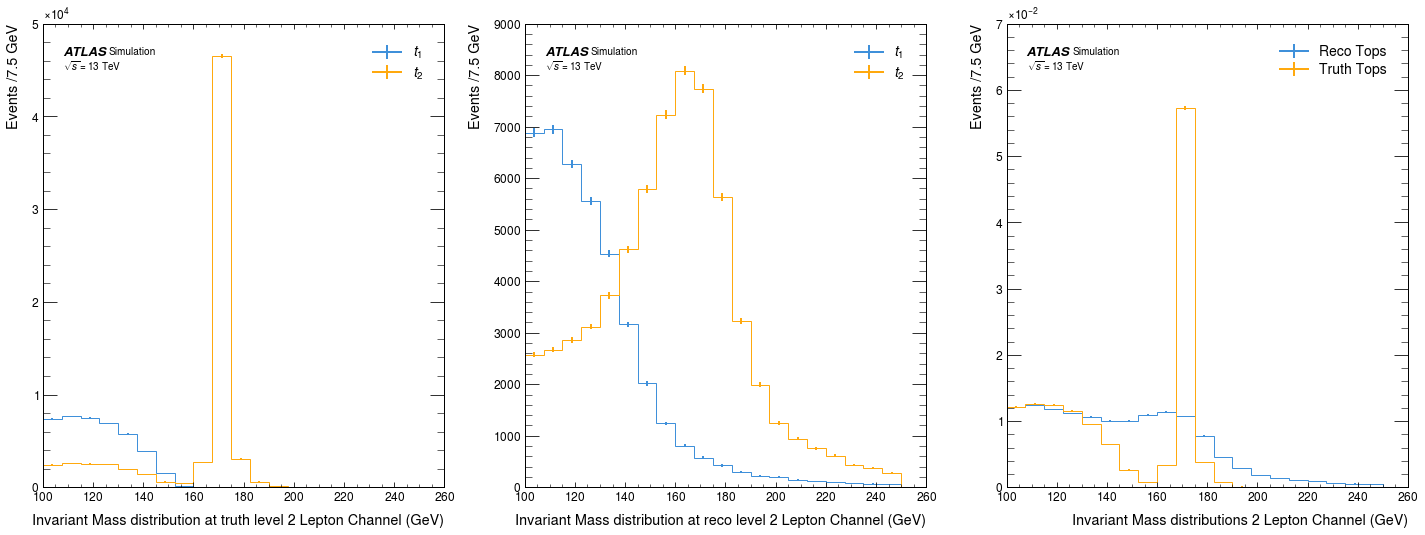

Peak bin center for truth tops: 175.00 GeV
Peak bin center for reco tops: 105.00 GeV
Peak bin center for Truth tops: 170.00 GeV
Peak bin center for Reco Tops: 107.00 GeV


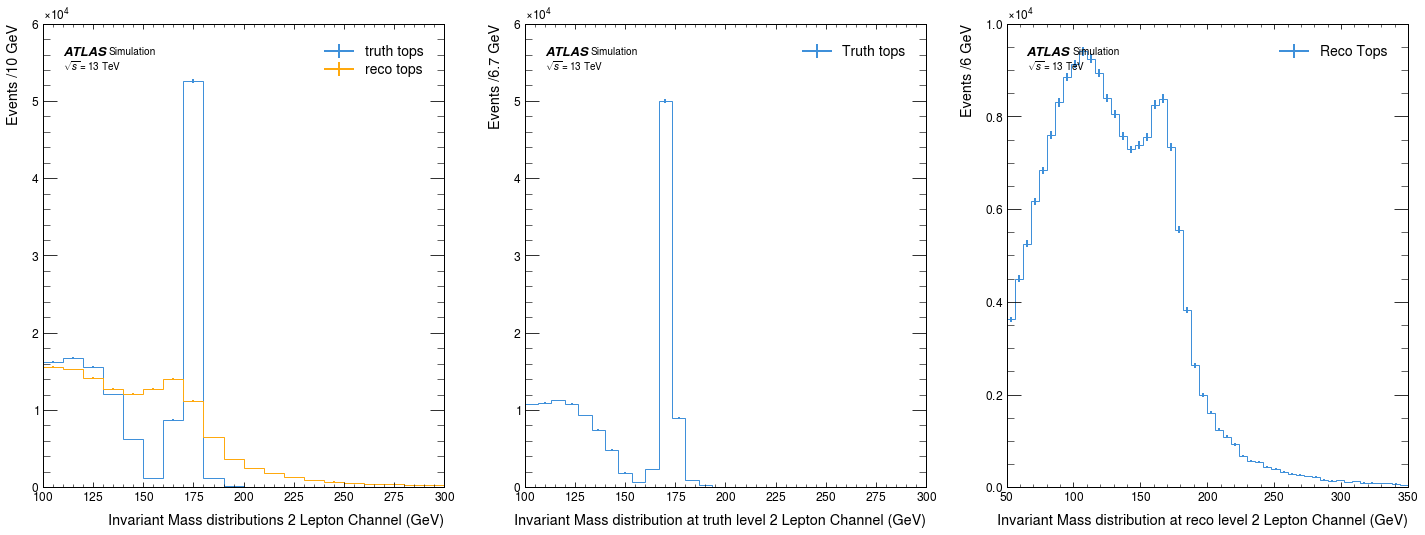

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tW_2L[:,0].m, fm_truth_tops_3tW_2L[:,1].m, fm_truth_tops_3tW_2L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([fm_reco_tops_3tW_2L[:,0].m, fm_reco_tops_3tW_2L[:,1].m, fm_reco_tops_3tW_2L[:,2].m], 20, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_3tW_2L.m,fm_full_truth_tops_3tW_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_3tW_2L[:,0].m, dm_truth_tops_3tW_2L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([dm_reco_tops_3tW_2L[:,0].m, dm_reco_tops_3tW_2L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_3tW_2L.m,dm_full_truth_tops_3tW_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_3tW_2L).m,ak.flatten(sm_reco_tops_3tW_2L).m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_3tW_2L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_3tW_2L).m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([fm_truth_tops_3tj_2L[:,0].m, fm_truth_tops_3tj_2L[:,1].m, fm_truth_tops_3tj_2L[:,2].m], 100, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([fm_reco_tops_3tj_2L[:,0].m, fm_reco_tops_3tj_2L[:,1].m, fm_reco_tops_3tj_2L[:,2].m], 100, [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
histogram([fm_full_reco_tops_3tj_2L.m,fm_full_truth_tops_3tj_2L.m], 100, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([dm_truth_tops_3tj_2L[:,0].m, dm_truth_tops_3tj_2L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[0], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([dm_reco_tops_3tj_2L[:,0].m, dm_reco_tops_3tj_2L[:,1].m], 20, [r'$t_1$', r'$t_2$'], ax[1], density = False, x_units='GeV', set_range=(100,250), print_peak=True)
ax[1].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
histogram([dm_full_reco_tops_3tj_2L.m,dm_full_truth_tops_3tj_2L.m], 20, ['Reco Tops', 'Truth Tops'], ax[2], density = True, x_units='GeV', print_peak=True, set_range=(100,250))
ax[2].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))
histogram([ak.flatten(sm_truth_tops_3tj_2L).m,ak.flatten(sm_reco_tops_3tj_2L).m], 20, [r'truth tops', r'reco tops'], ax[0], density = False, x_units='GeV', set_range=(100,300), print_peak=True)
ax[0].set_xlabel(r'Invariant Mass distributions 2 Lepton Channel (GeV)')
histogram([ak.flatten(sm_truth_tops_3tj_2L).m], 30, [r'Truth tops'], ax[1], density = False, x_units='GeV', print_peak=True, set_range=(100,300))
ax[1].set_xlabel(r'Invariant Mass distribution at truth level 2 Lepton Channel (GeV)')
histogram([ak.flatten(sm_reco_tops_3tj_2L).m], 50, ['Reco Tops'], ax[2], density = False, x_units='GeV', print_peak=True, set_range=(50,350))
ax[2].set_xlabel(r'Invariant Mass distribution at reco level 2 Lepton Channel (GeV)')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)
plt.subplots_adjust(hspace=0.25)
plt.show()

NameError: name 'plt' is not defined

## Partonic Variable Analysis

In [14]:
tops_4t = vector.zip({'pt':tm_reco_tops_4t_0L.pt,'eta':tm_reco_tops_4t_0L.eta,'phi':tm_reco_tops_4t_0L.phi, 'mass':tm_reco_tops_4t_0L.m})
tops_3t = vector.zip({'pt':fm_reco_tops_3t_0L.pt,'eta':fm_reco_tops_3t_0L.eta,'phi':fm_reco_tops_3t_0L.phi, 'mass':fm_reco_tops_3t_0L.m})

duos_4t = ak.combinations(tops_4t, 2, axis=1)
duos_3t = ak.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)

deltapt_4t = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

### Sorting

In [15]:
sorted_4t = tops_4t[ak.argsort(tops_4t.pt)]
highest_pt_4t = sorted_4t[:,-1]
middle_pt_4t = sorted_4t[:,-2]
lowest_pt_4t = sorted_4t[:,0]

sorted_3t = tops_3t[ak.argsort(tops_3t.pt)]
highest_pt_3t = sorted_3t[:,-1]
middle_pt_3t = sorted_3t[:,1]
lowest_pt_3t = sorted_3t[:,0]

In [16]:
sorted_4t = tops_4t[ak.argsort(tops_4t.eta)]
highest_eta_4t = sorted_4t[:,-1]
middle_eta_4t = sorted_4t[:,-2]
lowest_eta_4t = sorted_4t[:,0]

sorted_3t = tops_3t[ak.argsort(tops_3t.eta)]
highest_eta_3t = sorted_3t[:,-1]
middle_eta_3t = sorted_3t[:,1]
lowest_eta_3t = sorted_3t[:,0]

sorted_4t = tops_4t[ak.argsort(np.abs(tops_4t.eta))]
abs_highest_eta_4t = sorted_4t[:,-1]
abs_middle_eta_4t = sorted_4t[:,1]
abs_lowest_eta_4t = sorted_4t[:,0]

sorted_3t = tops_3t[ak.argsort(np.abs(tops_3t.eta))]
abs_highest_eta_3t = sorted_3t[:,-1]
abs_middle_eta_3t = sorted_3t[:,1]
abs_lowest_eta_3t = sorted_3t[:,0]

In [17]:
sorted_4t = tops_4t[ak.argsort(tops_4t.phi)]
highest_phi_4t = sorted_4t[:,-1]
middle_phi_4t = sorted_4t[:,1]
lowest_phi_4t = sorted_4t[:,0]

sorted_3t = tops_3t[ak.argsort(tops_3t.phi)]
highest_phi_3t = sorted_3t[:,-1]
middle_phi_3t = sorted_3t[:,1]
lowest_phi_3t = sorted_3t[:,0]

sorted_4t = tops_4t[ak.argsort(np.abs(tops_4t.phi))]
abs_highest_phi_4t = sorted_4t[:,-1]
abs_middle_phi_4t = sorted_4t[:,1]
abs_lowest_phi_4t = sorted_4t[:,0]

sorted_3t = tops_3t[ak.argsort(np.abs(tops_3t.phi))]
abs_highest_phi_3t = sorted_3t[:,-1]
abs_middle_phi_3t = sorted_3t[:,1]
abs_lowest_phi_3t = sorted_3t[:,0]

In [18]:
sorted_4t = tops_4t[ak.argsort(tops_4t.E)]
highest_e_4t = sorted_4t[:,-1]
middle_e_4t = sorted_4t[:,-2]
lowest_e_4t = sorted_4t[:,0]

sorted_3t = tops_3t[ak.argsort(tops_3t.E)]
highest_e_3t = sorted_3t[:,-1]
middle_e_3t = sorted_3t[:,1]
lowest_e_3t = sorted_3t[:,0]

### Calculations

In [19]:
pt_deltaR_4t = highest_pt_4t.deltaR(middle_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(middle_eta_4t)
abs_eta_deltaR_4t = abs_lowest_eta_4t.deltaR(abs_middle_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(middle_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_middle_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(middle_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_lowest_eta_3t.deltaR(abs_lowest_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

In [20]:
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(middle_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(middle_phi_4t))
low_delta_phi_4t = np.abs(middle_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(middle_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

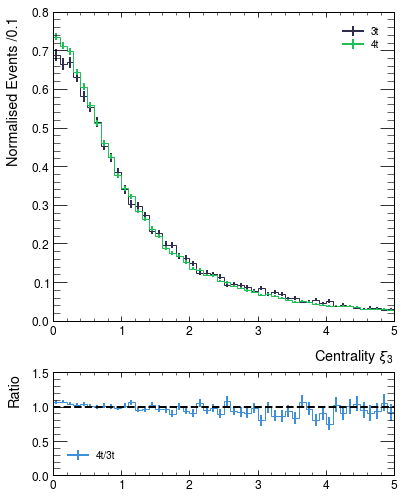

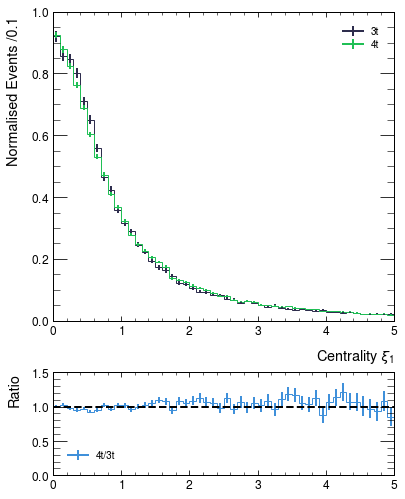

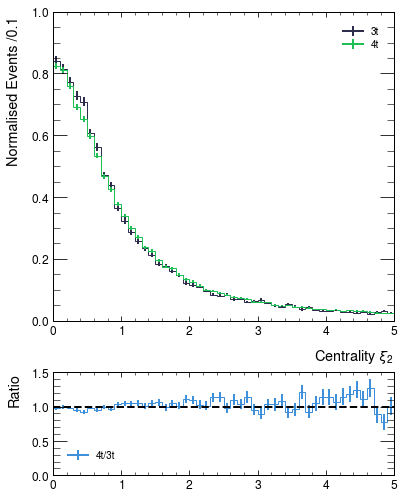

In [21]:
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, middle_pt_4t, lowest_pt_4t)
centrality_2_4t = centrality(middle_pt_4t, highest_pt_4t, lowest_pt_4t)
centrality_3_4t = centrality(lowest_pt_4t, highest_pt_4t, middle_pt_4t)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3,1]},figsize = (6,8))
histogram([centrality_3_3t, centrality_3_4t], 50, ['3t', '4t'], ax[0], density = True, set_range=(0,5), ratio=True, ratio_axes=ax[1], x_units='')
ax[0].set_xlabel(r'Centrality $\xi_3$')
fig.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_1_3t, centrality_1_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_1$')
plt.subplots_adjust(hspace=0.25)
plt.show()

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([centrality_2_3t, centrality_2_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,5), x_units='')
ax[0].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()


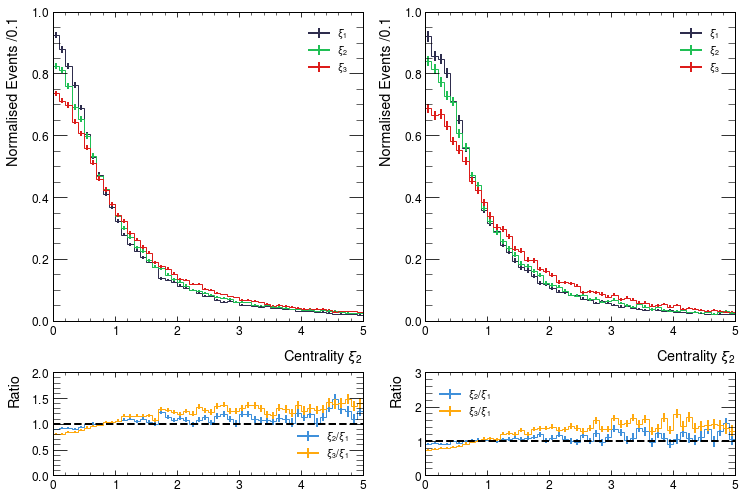

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (12,8))
histogram([centrality_1_4t, centrality_2_4t, centrality_3_4t], 50, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,0], density = True, ratio=True, ratio_axes=ax[1,0], set_range=(0,5), x_units='')
ax[0,0].set_xlabel(r'Centrality $\xi_2$')
histogram([centrality_1_3t, centrality_2_3t, centrality_3_3t], 50, [r'$\xi_1$', r'$\xi_2$', r'$\xi_3$'], ax[0,1], density = True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5), x_units='')
ax[0,1].set_xlabel(r'Centrality $\xi_2$')
plt.subplots_adjust(hspace=0.25)
plt.show()

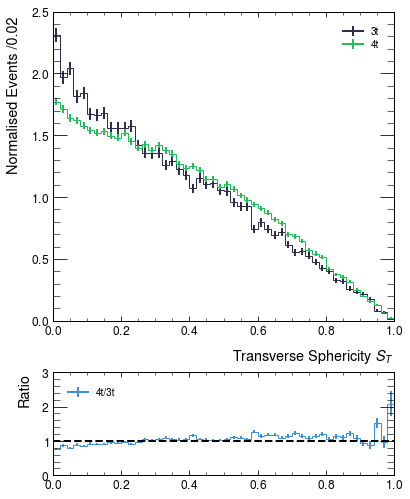

In [23]:
sum_pt_3t = np.sum(tops_3t.pt, axis=1)

S_xy_3t = np.zeros((len(tops_3t),2,2))


S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)


S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)

sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)

S_xy_4t = np.zeros((len(tops_4t),2,2))


S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)


S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)

sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_3t, sphericity_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,1), x_units='')
ax[0].set_xlabel(r'Transverse Sphericity $S_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

$\delta \mathcal{L} = \epsilon^\nu \left[ \frac{\partial \mathcal{L}}{\partial \phi_a} \partial_\nu \phi_a + \frac{\partial \mathcal{L}}{\partial (\partial
\mu \phi_a)} \partial\nu (\partial_\mu \phi_a) \right].$

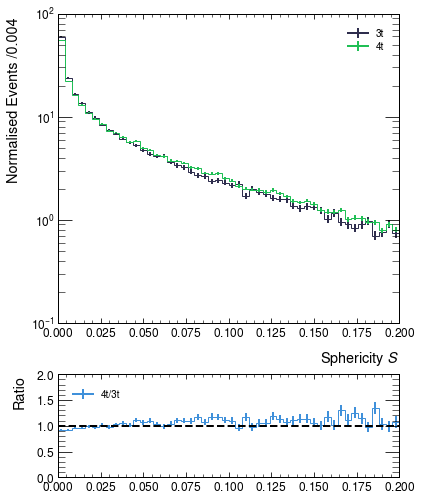

In [24]:
sum_p_3t = np.sum(tops_3t.p, axis=1)

S_xyz_3t = np.zeros((len(tops_3t),3,3))


S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)


S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)

sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)

S_xyz_4t = np.zeros((len(tops_4t),3,3))


S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)


S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)

sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([sphericity_3t, sphericity_4t], 50, ['3t', '4t'], ax[0], density = True, ratio=True, ratio_axes=ax[1], set_range=(0,0.2), x_units='')
ax[0].set_xlabel(r'Sphericity $S$')
ax[0].set_yscale('log')
plt.subplots_adjust(hspace=0.25)
plt.show()

### Plots

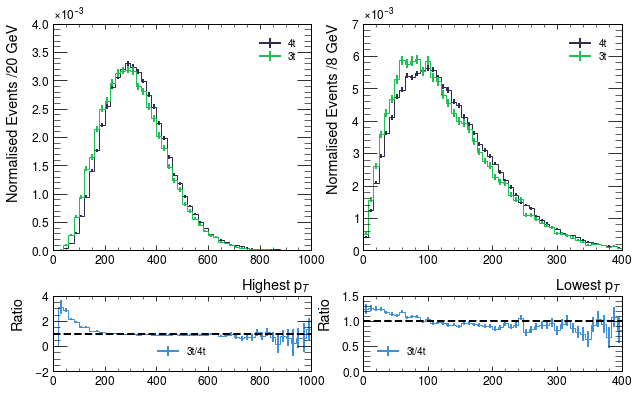

In [25]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.pt, highest_pt_3t.pt], 50, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,1000))
histogram([lowest_pt_4t.pt, lowest_pt_3t.pt], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,400))
ax[0,0].set_xlabel(r'Highest p$_T$')
ax[0,1].set_xlabel(r'Lowest p$_T$')
plt.subplots_adjust(hspace=0.3)
plt.show()

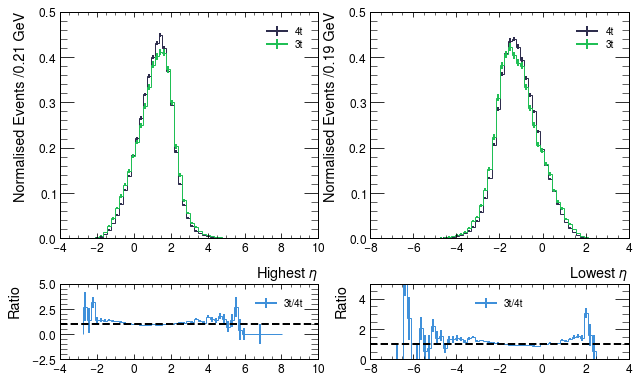

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_eta_4t.eta, highest_eta_3t.eta], 50, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
histogram([lowest_eta_4t.eta, lowest_eta_3t.eta], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,0].set_xlabel(r'Highest $\eta$')
ax[0,1].set_xlabel(r'Lowest $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

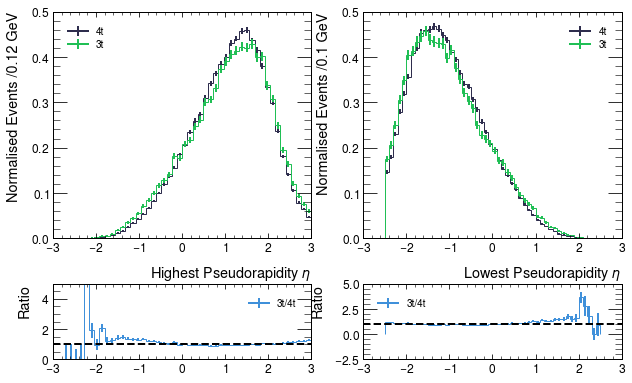

In [27]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_eta_4t.eta, highest_eta_3t.eta], 50, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(-3,3))
ax[0,0].set_xlabel(r'Highest Pseudorapidity $\eta$')
histogram([lowest_eta_4t.eta, lowest_eta_3t.eta], 50, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-2.5,2.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

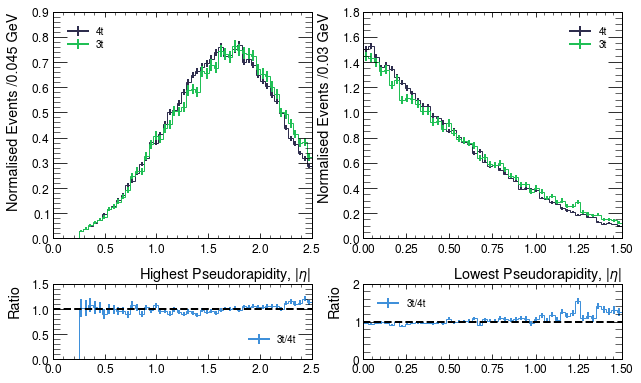

In [28]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_eta_4t.eta), np.abs(abs_highest_eta_3t.eta)], 50, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0.25,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity, $|\eta|$')
histogram([np.abs(abs_lowest_eta_4t.eta), np.abs(abs_lowest_eta_3t.eta)], 50, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,1.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity, $|\eta|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

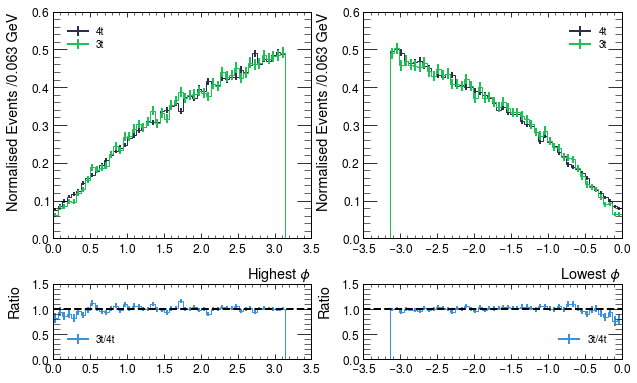

In [29]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_phi_4t.phi, highest_phi_3t.phi], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,np.pi))
ax[0,0].set_xlabel(r'Highest $\phi$')
histogram([lowest_phi_4t.phi, lowest_phi_3t.phi], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-np.pi,0))
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.3)
plt.show()

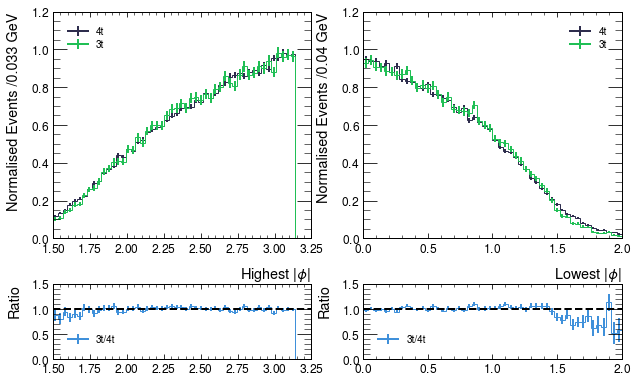

In [30]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_phi_4t.phi), np.abs(abs_highest_phi_3t.phi)], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1.5,np.pi))
ax[0,0].set_xlabel(r'Highest $|\phi|$')
histogram([np.abs(abs_lowest_phi_4t.phi), np.abs(abs_lowest_phi_3t.phi)], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,2))
ax[0,1].set_xlabel(r'Lowest $|\phi|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

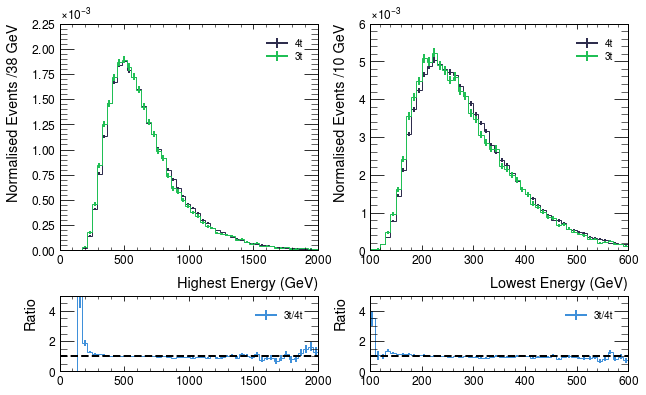

In [31]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_e_4t.E, highest_e_3t.E], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(100,2000))
ax[0,0].set_xlabel(r'Highest Energy (GeV)')
histogram([lowest_e_4t.E, lowest_e_3t.E], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(100,600))
ax[0,1].set_xlabel(r'Lowest Energy (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

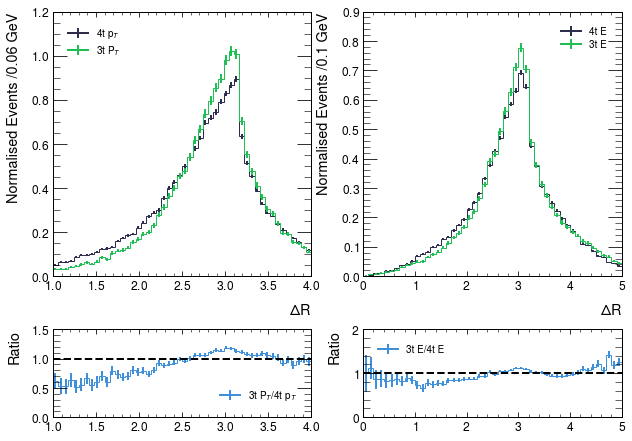

In [32]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([pt_deltaR_4t, pt_deltaR_3t], 50, [r'4t p$_T$', r'3t P$_T$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([e_deltaR_4t, e_deltaR_3t], 50, [r'4t E', r'3t E'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

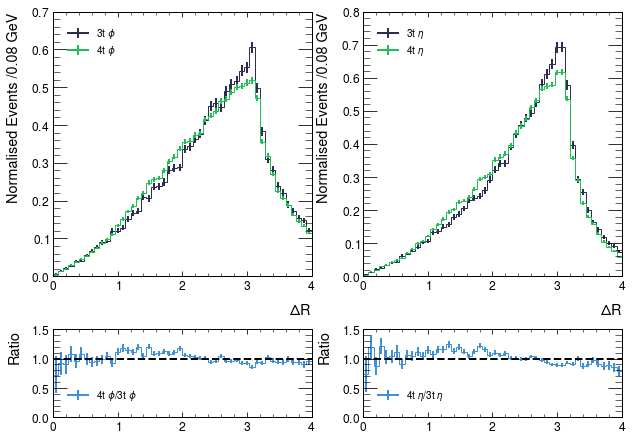

In [33]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([phi_deltaR_3t, phi_deltaR_4t], 50, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([eta_deltaR_3t, eta_deltaR_4t], 50, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

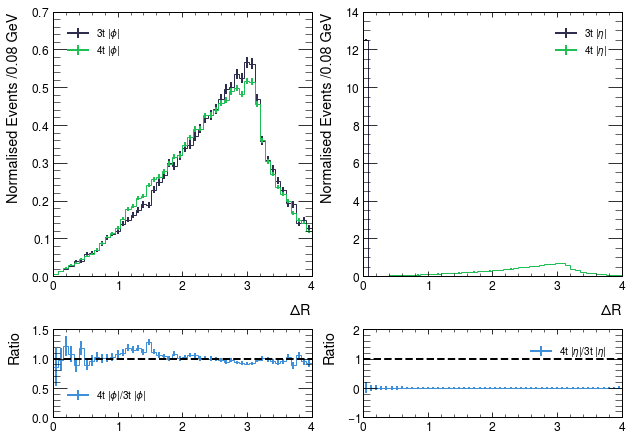

In [34]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([abs_phi_deltaR_3t, abs_phi_deltaR_4t], 50, [r'3t $|\phi|$', r'4t $|\phi|$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([abs_eta_deltaR_3t, abs_eta_deltaR_4t], 50, [r'3t $|\eta|$', r'4t $|\eta|$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

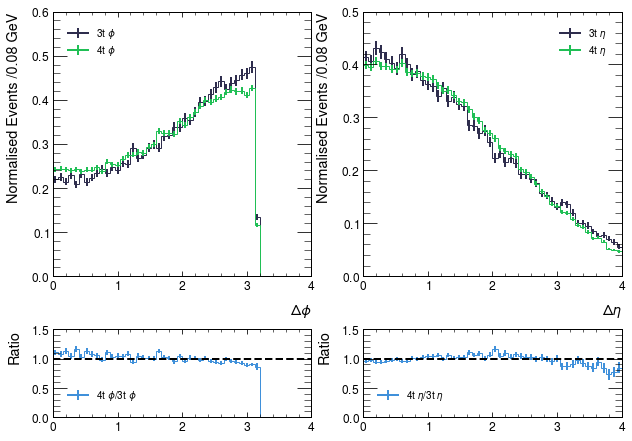

In [35]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([high_delta_phi_3t, high_delta_phi_4t], 50, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([high_delta_eta_3t, high_delta_eta_4t], 50, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

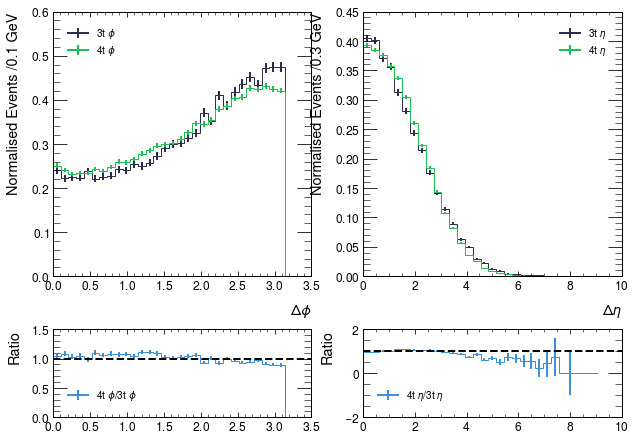

In [36]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([low_delta_phi_3t, low_delta_phi_4t], 30, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([low_delta_eta_3t, low_delta_eta_4t], 30, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

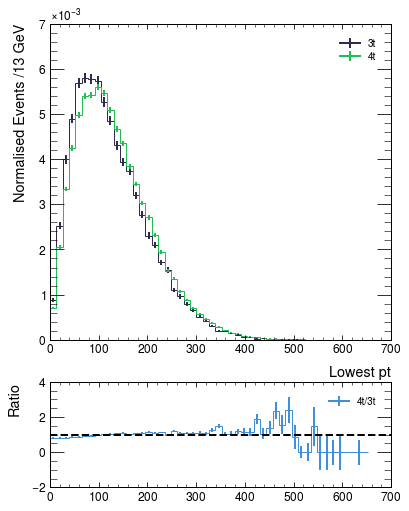

In [37]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([lowest_pt_3t.rho, lowest_pt_4t.rho], 50, ['3t', '4t'], ax[0],density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('Lowest pt')
plt.show()

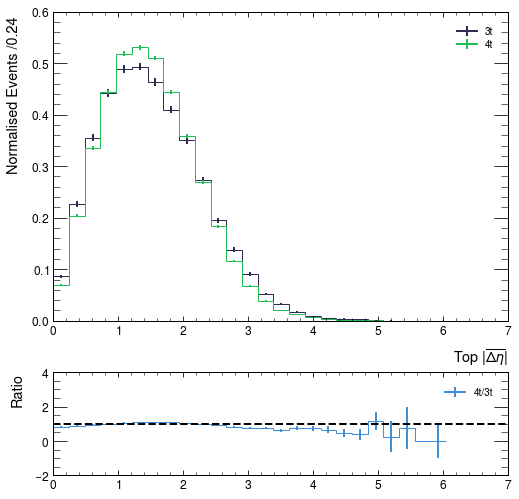

In [38]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaeta_3t,deltaeta_4t], 25, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $|\overline{\Delta\eta}|$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

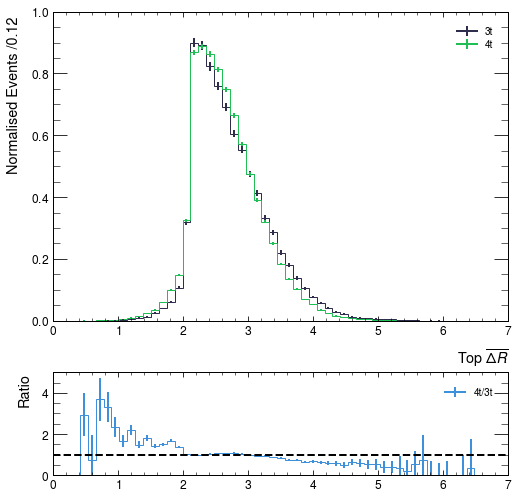

In [39]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaR_3t,deltaR_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta R}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

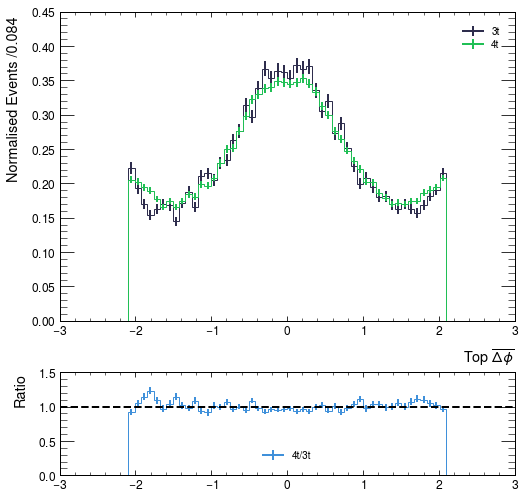

In [40]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([deltaphi_3t,deltaphi_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'Top $\overline{\Delta \phi}$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

In [41]:
hep.style.use("ATLAS")

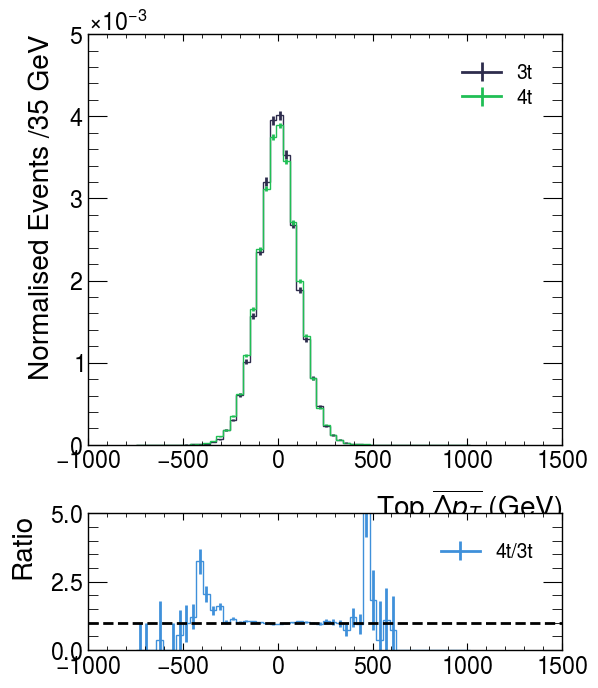

In [43]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(6,8))
histogram([deltapt_3t,deltapt_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV')
ax[0].set_xlabel(r'Top $\overline{\Delta p_T}$ (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

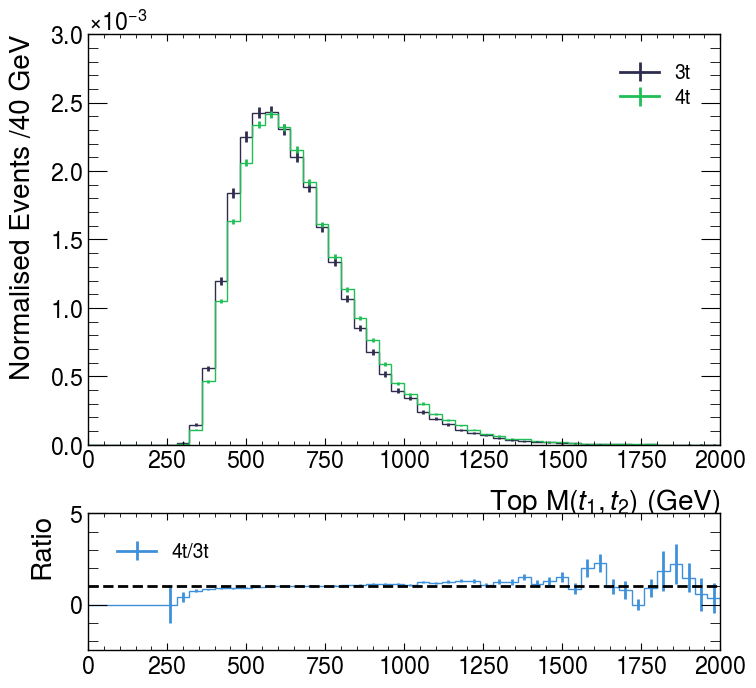

In [44]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(8,8))
histogram([duo_masses_3t,duo_masses_4t], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV', set_range=(0,2000))
ax[0].set_xlabel(r'Top M($t_1,t_2$) (GeV)')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

In [45]:
truth_tops

NameError: name 'truth_tops' is not defined

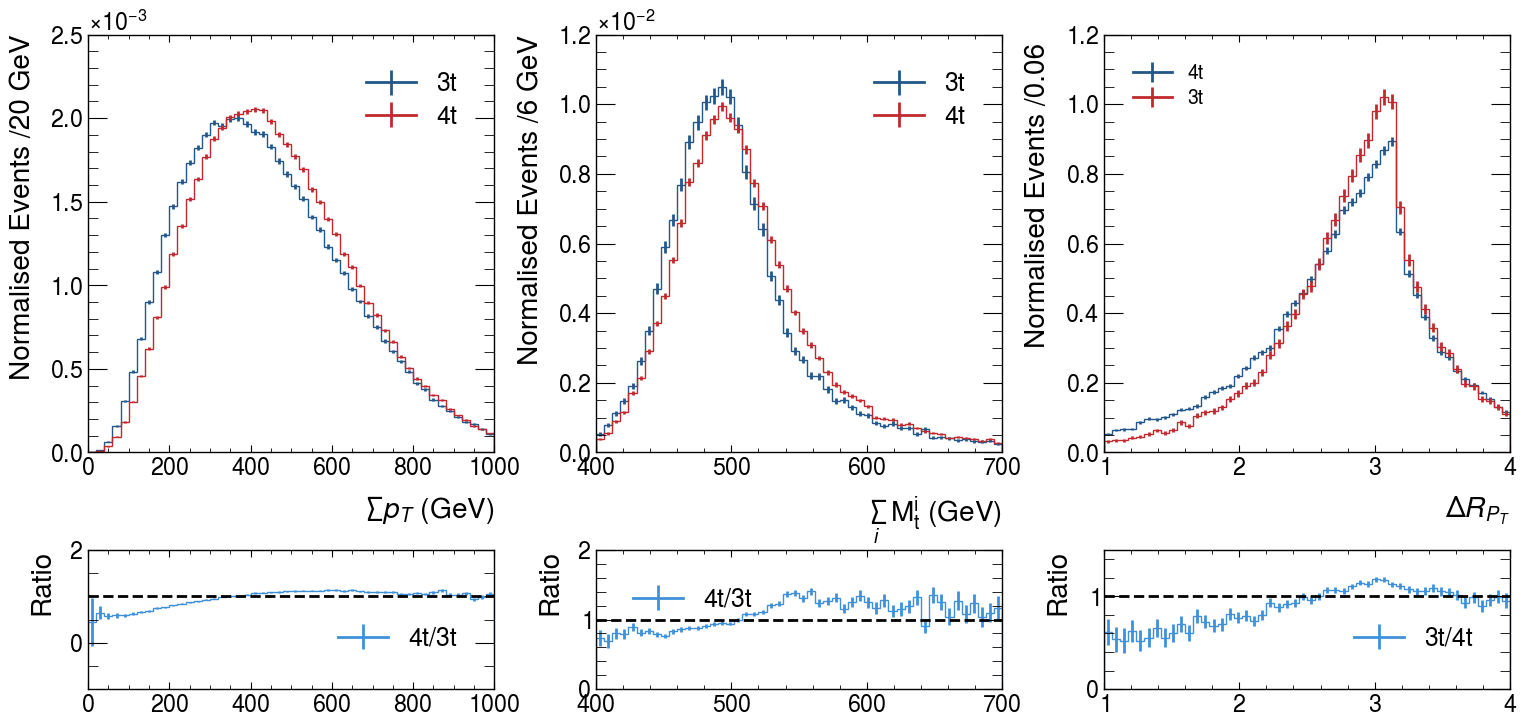

In [65]:
ak.sum(tops_3t, axis=1).m
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(18,8.5))
histogram([ak.sum(ak.concatenate((dm_truth_tops_3tj_0L, dm_truth_tops_3tW_0L)).pt, axis=1),ak.sum(dm_truth_tops_4t_0L.pt, axis=1)], 50, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='GeV', set_range=(0,1000))
histogram([ak.sum(tops_3t.m, axis=1),ak.sum(tops_4t.m, axis=1)], 50, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='GeV', set_range=(400,700))
histogram([pt_deltaR_4t, pt_deltaR_3t], 50, [r'4t', r'3t'], ax[0,2],density=True, ratio=True, ratio_axes=ax[1,2], set_range=(1,4), x_units='')
ax[0,0].set_xlabel(r'$\sum p_T$ (GeV)')
ax[0,1].set_xlabel(r'$\sum_i$ $ \mathrm{M_t^i}$ (GeV)')
ax[0,2].set_xlabel(r'$\Delta R_{P_T}$')
ax[0,0].legend(fontsize=18)
ax[0,1].legend(fontsize=18)
ax[1,0].legend(fontsize=18)
ax[1,1].legend(loc='upper left',fontsize=18)
ax[1,2].legend(fontsize=18)
plt.subplots_adjust(hspace=0.35, wspace=0.25)
plt.savefig('top_differences.png', dpi=300)
plt.show()

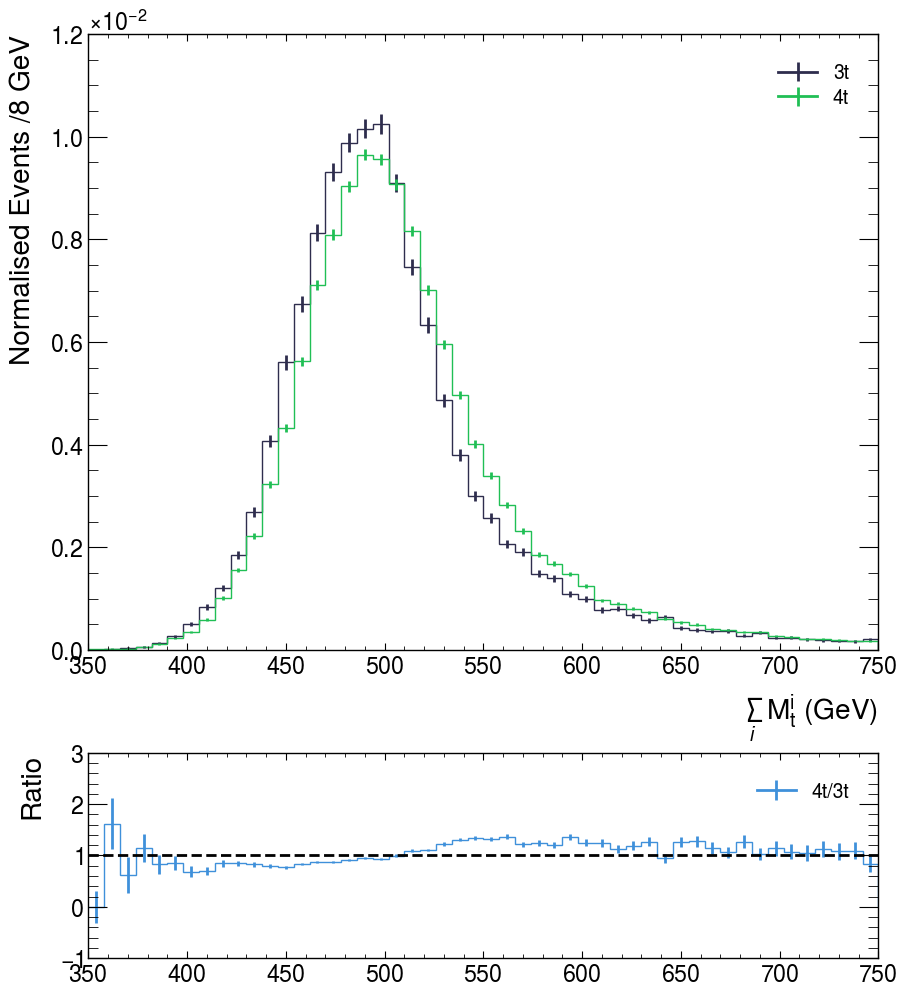

In [47]:
ak.sum(tops_3t, axis=1).m
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,12))
histogram([ak.sum(tops_3t.m, axis=1),ak.sum(tops_4t.m, axis=1)], 50, ['3t','4t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='GeV', set_range=(350,750))
ax[0].set_xlabel(r'$\sum_i$ $ \mathrm{M_t^i}$ (GeV)')
plt.savefig('sum_mass_top.png')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

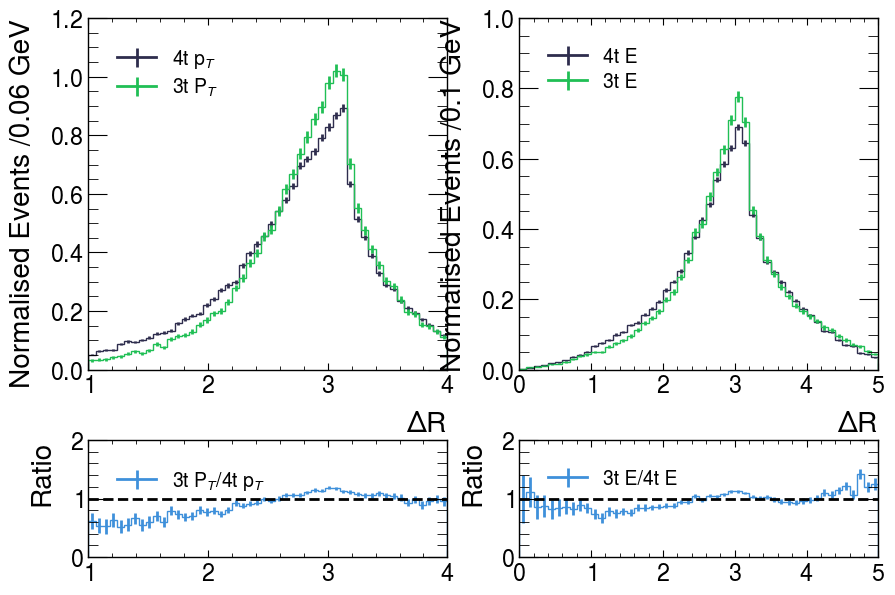

In [48]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([pt_deltaR_4t, pt_deltaR_3t], 50, [r'4t p$_T$', r'3t P$_T$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([e_deltaR_4t, e_deltaR_3t], 50, [r'4t E', r'3t E'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()